In [1]:
import sys
sys.path.append("./packages/")


In [2]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import warnings
import calmap
from datetime import datetime
import pandas as pd
from FeatureEngineering import FeatureEngineer
warnings.filterwarnings("ignore")


## 0. Import et mise en forme de la data

> Importation

In [3]:
DATA_PATH = './../data/'

df = pd.read_csv(f'{DATA_PATH}household_power_consumption.txt',
                 sep=';',                            # separateur = ;
                 header=0,                           # ligne des header = 1ère ligne
                 low_memory=False,                   # parsing complet
                 infer_datetime_format=True,         # parsing des dates
                 )


> 0.2 Mise en forme des dtypes de date et création des variables de temps

dire c'est quoi les étapes qui ont été faites

In [5]:
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

fe = FeatureEngineer(df)
df = fe.process_data(cols)
df.head()


Date      Time  Global_active_power  \
datetime                                                        
2006-12-16 17:24:00 2006-12-16  17:24:00             4.214844   
2006-12-16 17:25:00 2006-12-16  17:25:00             5.359375   
2006-12-16 17:26:00 2006-12-16  17:26:00             5.375000   
2006-12-16 17:27:00 2006-12-16  17:27:00             5.386719   
2006-12-16 17:28:00 2006-12-16  17:28:00             3.666016   

                     Global_reactive_power  Voltage  Global_intensity  \
datetime                                                                
2006-12-16 17:24:00               0.417969  234.875         18.406250   
2006-12-16 17:25:00               0.436035  233.625         23.000000   
2006-12-16 17:26:00               0.498047  233.250         23.000000   
2006-12-16 17:27:00               0.501953  233.750         23.000000   
2006-12-16 17:28:00               0.527832  235.625         15.796875   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  day  \
datetime                                                                   
2006-12-16 17:24:00             0.0             1.0            17.0   16   
2006-12-16 17:25:00             0.0             1.0            16.0   16   
2006-12-16 17:26:00             0.0             2.0            17.0   16   
2006-12-16 17:27:00             0.0             1.0            17.0   16   
2006-12-16 17:28:00             0.0             1.0            17.0   16   

                     month  year  Global_active_power_Wh  other_submetering  
datetime                                                                     
2006-12-16 17:24:00     12  2006               70.247398          52.247398  
2006-12-16 17:25:00     12  2006               89.322914          72.322914  
2006-12-16 17:26:00     12  2006               89.583336          70.583336  
2006-12-16 17:27:00     12  2006               89.778648          71.778648  
2006-12-16 17:28:00     12  2006               61.100262          43.100262

## 1. Explication du problème de machine learning que vous souhaitez résoudre

Georges Hebrail et Alice Berard, employés d'EDF travaillant dans le pôle R&D, ont mis à disposition des [données de consommation éléctrique](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#) des ménages de Sceaux, une ville située à 7km de Paris. Ces données couvrent la période du 16 décembre 2006 au 26 novembre 2010. Bien que ces données n'aient pas été associées à une problématique particulière et qu'aucun papier de recherche n'ait été publié sur ce sujet, nous les considérons comme une excellente base de départ pour notre projet de Deep Learning sur des séries temporelles.  

Nous imaginons trois possibles problématiques pour ce sujet:
- Prédire la puissance consommée active ;
- Prédire la puissance consommée réactive ;
- Prédire la puissance consommée apparente: $\sqrt(Global\_active\_power^2 + Global\_reactive\_power^2)$.

Dans tous les cas, l'objectif est d'optimiser la production d'électricité d'EDF en évitant la surproduction, ce qui permet de réduire les coûts et l'impact environnemental. En prévoyant les pics de consommation, il est également possible d'informer les ménages afin qu'ils puissent adapter leur consommation et réduire leur impact. Finalement, nous allons prédire la puissance consommée active, qui représente l'énergie effectivement transformée et utilisée par les ménages. La puissance réactive, quant à elle, est une puissance électromagnétique latente dans le réseau électrique, produite par des appareils tels que des bobines ou des moteurs. Cette énergie n'est pas facturée par EDF et suppose un coût, cependant elle est essentielle pour faire fonctionner ces types d'appareils. Il faut noter que la puissance réactive est assez stable dans le réseau électrique, ce qui suppose un bruit si on s'intéresse à prédire la somme des deux, la puissance consommée apparente.

Il est important de noter qu'il faut définir un horizon de prédiction. Pour cela, nous nous sommes intéressés au [parc électrique](https://www.statistiques.developpement-durable.gouv.fr/edition-numerique/chiffres-cles-energie-2021/6-bilan-energetique-de-la-france#:~:text=Le%20bouquet%20%C3%A9nerg%C3%A9tique%20primaire%20r%C3%A9el,d%C3%A9chets%20et%202%20%25%20de%20charbon.) français. Nous avons appris que la production électrique peut s'adapter en quelques minutes si le changement n'est pas de plus de 50% de la production entre $t$ et $t+1$. Si c'était le cas, il faudrait arrêter la production nucléaire et cela pourrait prendre quelques heures dans le meilleur des cas. Cependant, des alternatives existent, comme le stockage d'électricité dans des batteries, bien que cela soit coûteux. En conséquence de la rapide adaptation de la production, nous trouvons pertinent de prédire dans la minute. Nous serons donc très proches de ce qu'en finance est appelé "nowcasting" qui est de prédire dans la minute ou même dans la seconde qui vient.


## 2. Présentation du jeu de données

### Description du jeu de données de consommation électrique

Le jeu de données de consommation électrique est fourni par le pôle R&D d'EDF et contient les données de consommation électrique des ménages de Sceaux entre le 16 décembre 2006 et le 26 novembre 2010, à la minute près, pour un total de 2 049 280 observations. 

Il est important de noter que les données sont en format texte séparées par des points-virgules (;) et que les valeurs manquantes sont représentées par des champs vides. Nous devrons donc travailler sur le formatage du DataFrame pour avoir une bonne lecture de la base de données.

### Variables

La base de données brute est composée de 9 variables :  
- `Date` : La date (au format dd/mm/yyyy)
- `Time` : L'heure (au format hh:mm:ss)
- `Global_active_power` : La puissance active moyenne par minute dans l'ensemble du foyer (en kilowatts)
- `Global_reactive_power` : La puissance réactive moyenne par minute dans l'ensemble du foyer (en kilowatts)
- `Voltage` : La tension moyenne par minute (en volts)
- `Global_intensity` : L'intensité de courant moyenne par minute dans l'ensemble du foyer (en ampères)
- `Sub_metering_1` : Le sous-compteur d'énergie n°1 (en watt-heures d'énergie active). Il correspond à la cuisine, contenant principalement un lave-vaisselle, un four et un micro-ondes (les plaques de cuisson ne sont pas électriques mais alimentées au gaz).
- `Sub_metering_2` : Le sous-compteur d'énergie n°2 (en watt-heures d'énergie active). Il correspond à la buanderie, contenant une machine à laver, un sèche-linge, un réfrigérateur et un éclairage.
- `Sub_metering_3` : Le sous-compteur d'énergie n°3 (en watt-heures d'énergie active). Il correspond à un chauffe-eau électrique et un climatiseur.
- `other_metering`: Il correspond à tout autre consommation éléctrique (en watt-heures d'énergie active) = $(global\_active\_power*1000/60 - sub\_metering\_1 - sub\_metering\_2 - sub\_metering\_3)$

In [106]:
from Plotter import GeneralPresentator
gs = GeneralPresentator(df)
gs.print_basic_prez()


Column Names:
['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'day', 'month', 'year', 'Global_active_power_Wh', 'other_submetering']

Data Types:


Date      Time Global_active_power Global_reactive_power  \
0  datetime64[ns]  category             float16               float16   

   Voltage Global_intensity Sub_metering_1 Sub_metering_2 Sub_metering_3  \
0  float16          float16        float16        float16        float16   

    day month   year Global_active_power_Wh other_submetering  
0  int8  int8  int16                float32           float32


Basic Statistics:


Global_active_power  Global_reactive_power      Voltage  \
count         2.049280e+06           2.049280e+06  2049280.000   
mean                   NaN                    NaN          NaN   
std           0.000000e+00           0.000000e+00        0.000   
min           7.598877e-02           0.000000e+00      223.250   
25%           3.081055e-01           4.800415e-02      239.000   
50%           6.020508e-01           9.997559e-02      241.000   
75%           1.528320e+00           1.939697e-01      242.875   
max           1.112500e+01           1.389648e+00      254.125   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
count      2.049280e+06       2049280.0       2049280.0       2049280.0   
mean                NaN             NaN             NaN             NaN   
std        0.000000e+00             0.0             0.0             0.0   
min        1.999512e-01             0.0             0.0             0.0   
25%        1.400391e+00             0.0             0.0             0.0   
50%        2.599609e+00             0.0             0.0             1.0   
75%        6.398438e+00             0.0             1.0            17.0   
max        4.840625e+01            88.0            80.0            31.0   

                day         month          year  Global_active_power_Wh  \
count  2.049280e+06  2.049280e+06  2.049280e+06            2.049280e+06   
mean   1.571245e+01  6.454433e+00  2.008425e+03            1.819356e+01   
std    8.801670e+00  3.423209e+00  1.124388e+00            1.762157e+01   
min    1.000000e+00  1.000000e+00  2.006000e+03            1.266479e+00   
25%    8.000000e+00  3.000000e+00  2.007000e+03            5.135091e+00   
50%    1.600000e+01  6.000000e+00  2.008000e+03            1.003418e+01   
75%    2.300000e+01  9.000000e+00  2.009000e+03            2.547201e+01   
max    3.100000e+01  1.200000e+01  2.010000e+03            1.854167e+02   

       other_submetering  
count       2.049280e+06  
mean        9.314664e+00  
std         9.585917e+00  
min        -2.404947e+00  
25%         3.802734e+00  
50%         5.501302e+00  
75%         1.036914e+01  
max         1.248385e+02


No missing values found.

Unique values for day:
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15]

Unique values for month:
[12  1  2  3  4  5  6  7  8  9 10 11]

Unique values for year:
[2006 2007 2008 2009 2010]

Sample Data:


Date      Time  Global_active_power  \
datetime                                                        
2006-12-16 17:24:00 2006-12-16  17:24:00             4.214844   
2006-12-16 17:25:00 2006-12-16  17:25:00             5.359375   
2006-12-16 17:26:00 2006-12-16  17:26:00             5.375000   
2006-12-16 17:27:00 2006-12-16  17:27:00             5.386719   
2006-12-16 17:28:00 2006-12-16  17:28:00             3.666016   

                     Global_reactive_power  Voltage  Global_intensity  \
datetime                                                                
2006-12-16 17:24:00               0.417969  234.875         18.406250   
2006-12-16 17:25:00               0.436035  233.625         23.000000   
2006-12-16 17:26:00               0.498047  233.250         23.000000   
2006-12-16 17:27:00               0.501953  233.750         23.000000   
2006-12-16 17:28:00               0.527832  235.625         15.796875   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  day  \
datetime                                                                   
2006-12-16 17:24:00             0.0             1.0            17.0   16   
2006-12-16 17:25:00             0.0             1.0            16.0   16   
2006-12-16 17:26:00             0.0             2.0            17.0   16   
2006-12-16 17:27:00             0.0             1.0            17.0   16   
2006-12-16 17:28:00             0.0             1.0            17.0   16   

                     month  year  Global_active_power_Wh  other_submetering  
datetime                                                                     
2006-12-16 17:24:00     12  2006               70.247398          52.247398  
2006-12-16 17:25:00     12  2006               89.322914          72.322914  
2006-12-16 17:26:00     12  2006               89.583336          70.583336  
2006-12-16 17:27:00     12  2006               89.778648          71.778648  
2006-12-16 17:28:00     12  2006               61.100262          43.100262

## 3. Exploration du jeu de données (Analyse descriptive, statistiques descriptives, visualisation)

In [107]:
from Plotter import DataPlotter
TARGET = 'Global_active_power_Wh'
dataplots = DataPlotter(df)


> Profiling


In [108]:
# dataplots.data_profiling(granularity="3M")


> Calendar overview

In [109]:
# create the treemap
# fig = px.treemap(df, path=["year", "month", "day"], values="Global_active_power")

# show the plot
# fig.show()


# to do: sortir la proportion entre metering par mois

Lorsque l'on étudie la consommation électrique totale, il est évident que celle-ci est très saisonnière. En effet, durant l'hiver, la demande en énergie augmente considérablement en raison du chauffage, car il s'agit d'une ville plutôt froide. À l'inverse, pendant l'été et les vacances, la demande diminue. Malgré cela, la consommation électrique reste globalement stable d'une année sur l'autre, bien que l'on remarque une légère hausse de la demande les week-ends. Il est important de souligner que le chauffage représente la majeure partie de la consommation électrique.

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

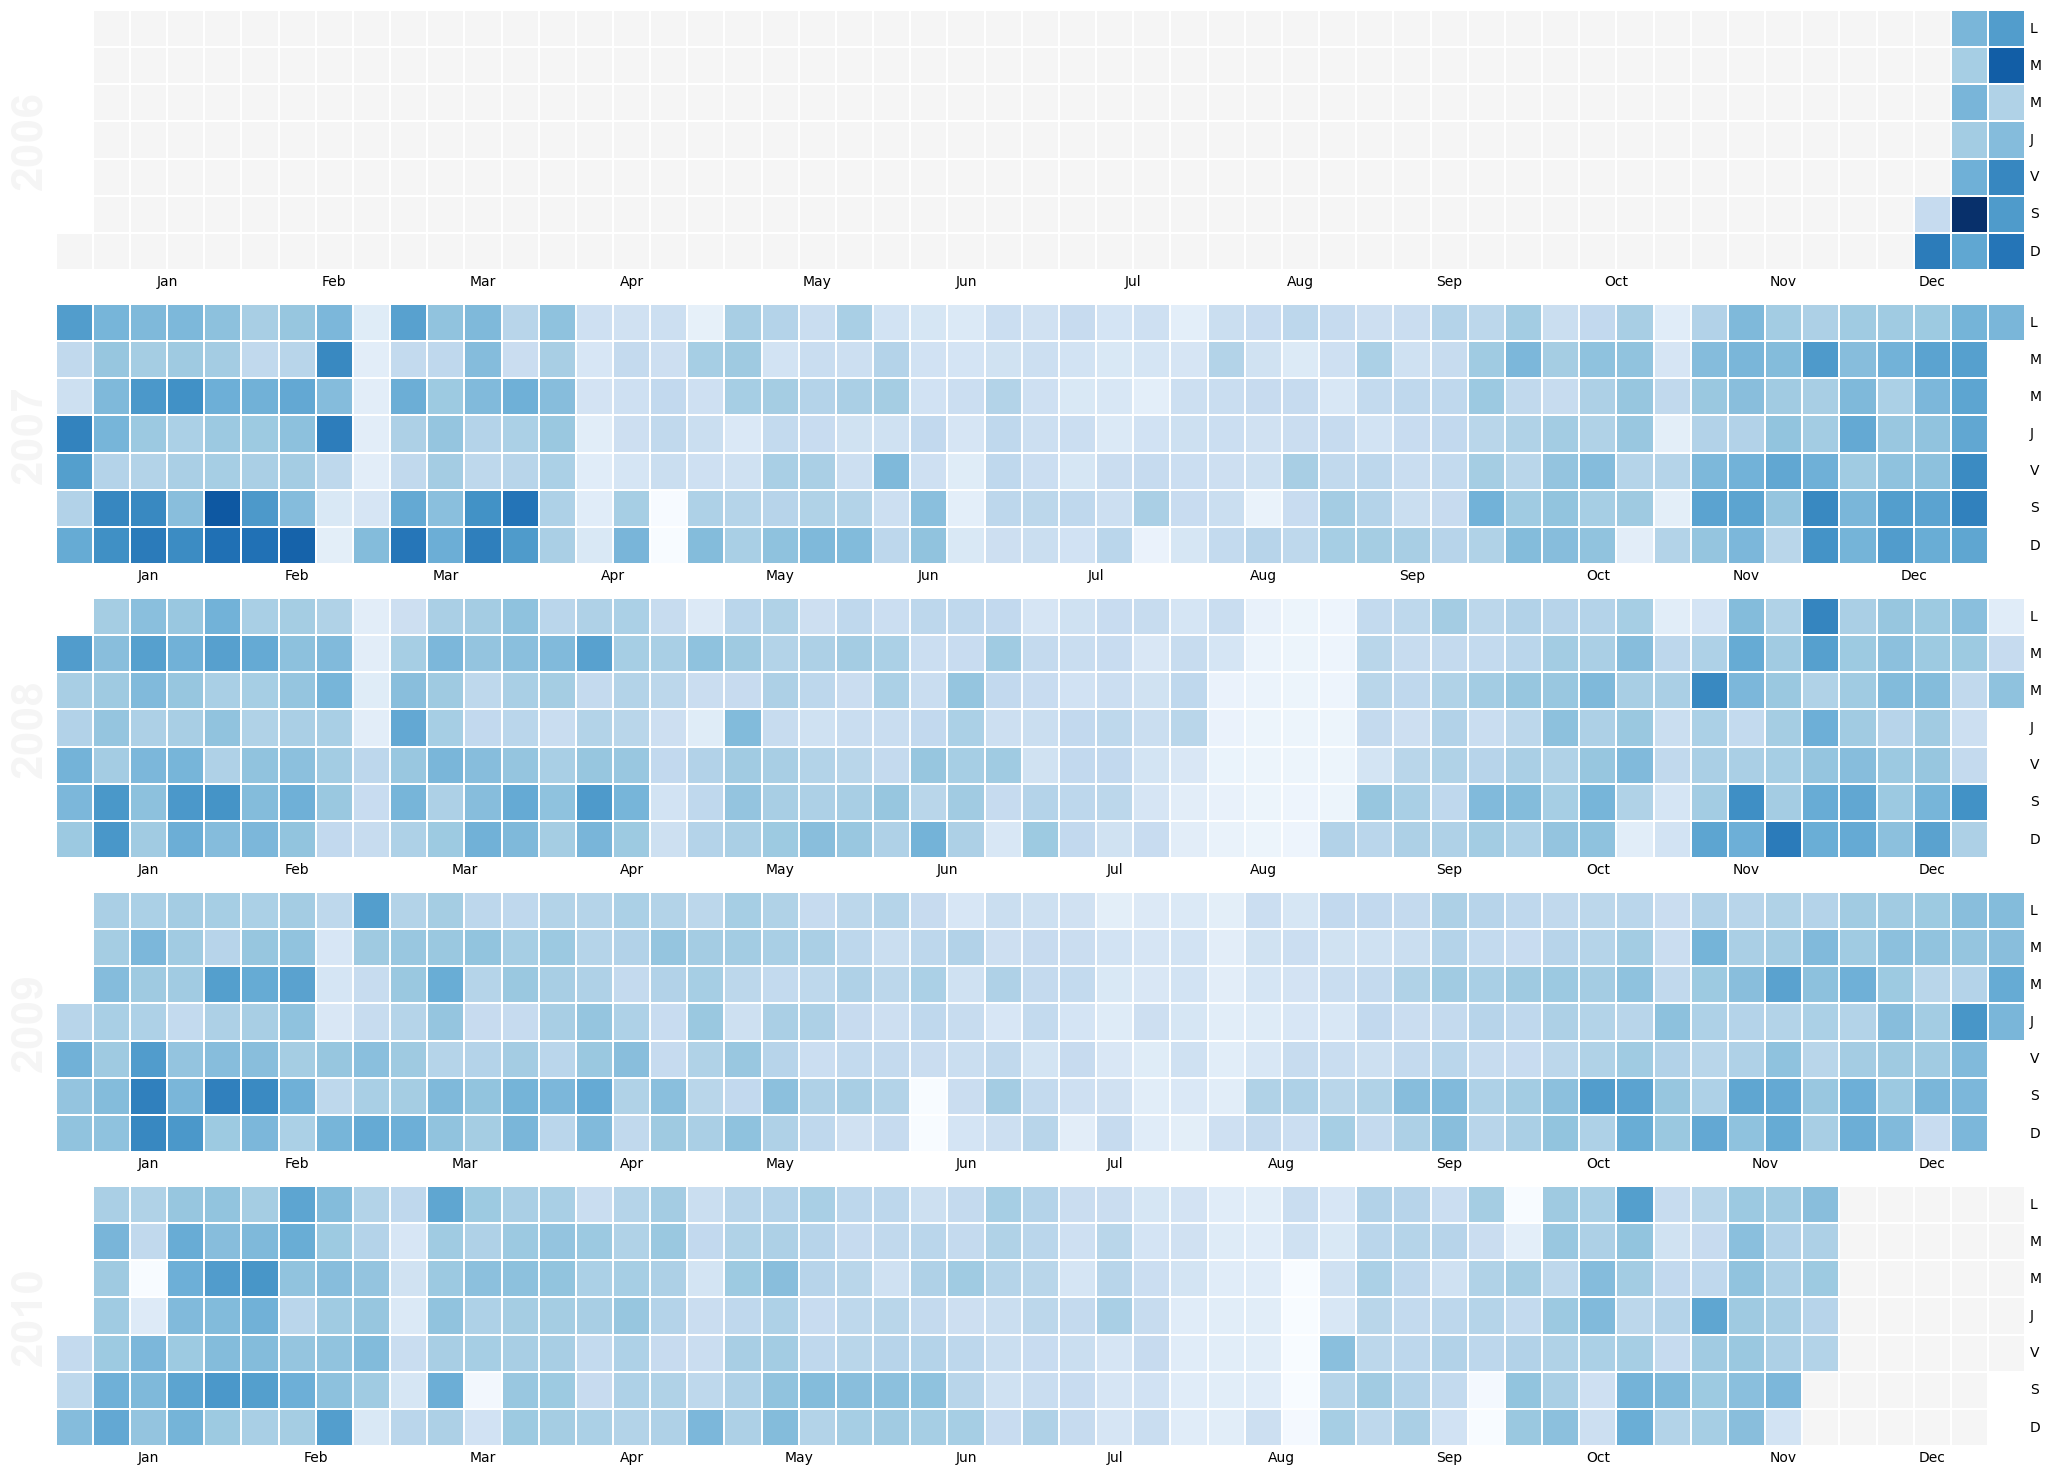

In [110]:
calmap.calendarplot(df[TARGET], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


En examinant de plus près le sous-comptage de l'électricité dans la cuisine, nous pouvons observer une augmentation de la consommation électrique les week-ends, tandis que cette dernière diminue pendant les vacances et l'été. Cependant, il y a certains jours où la consommation d'énergie augmente sensiblement, et nous pouvons présumer qu'il s'agit des jours fériés.

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

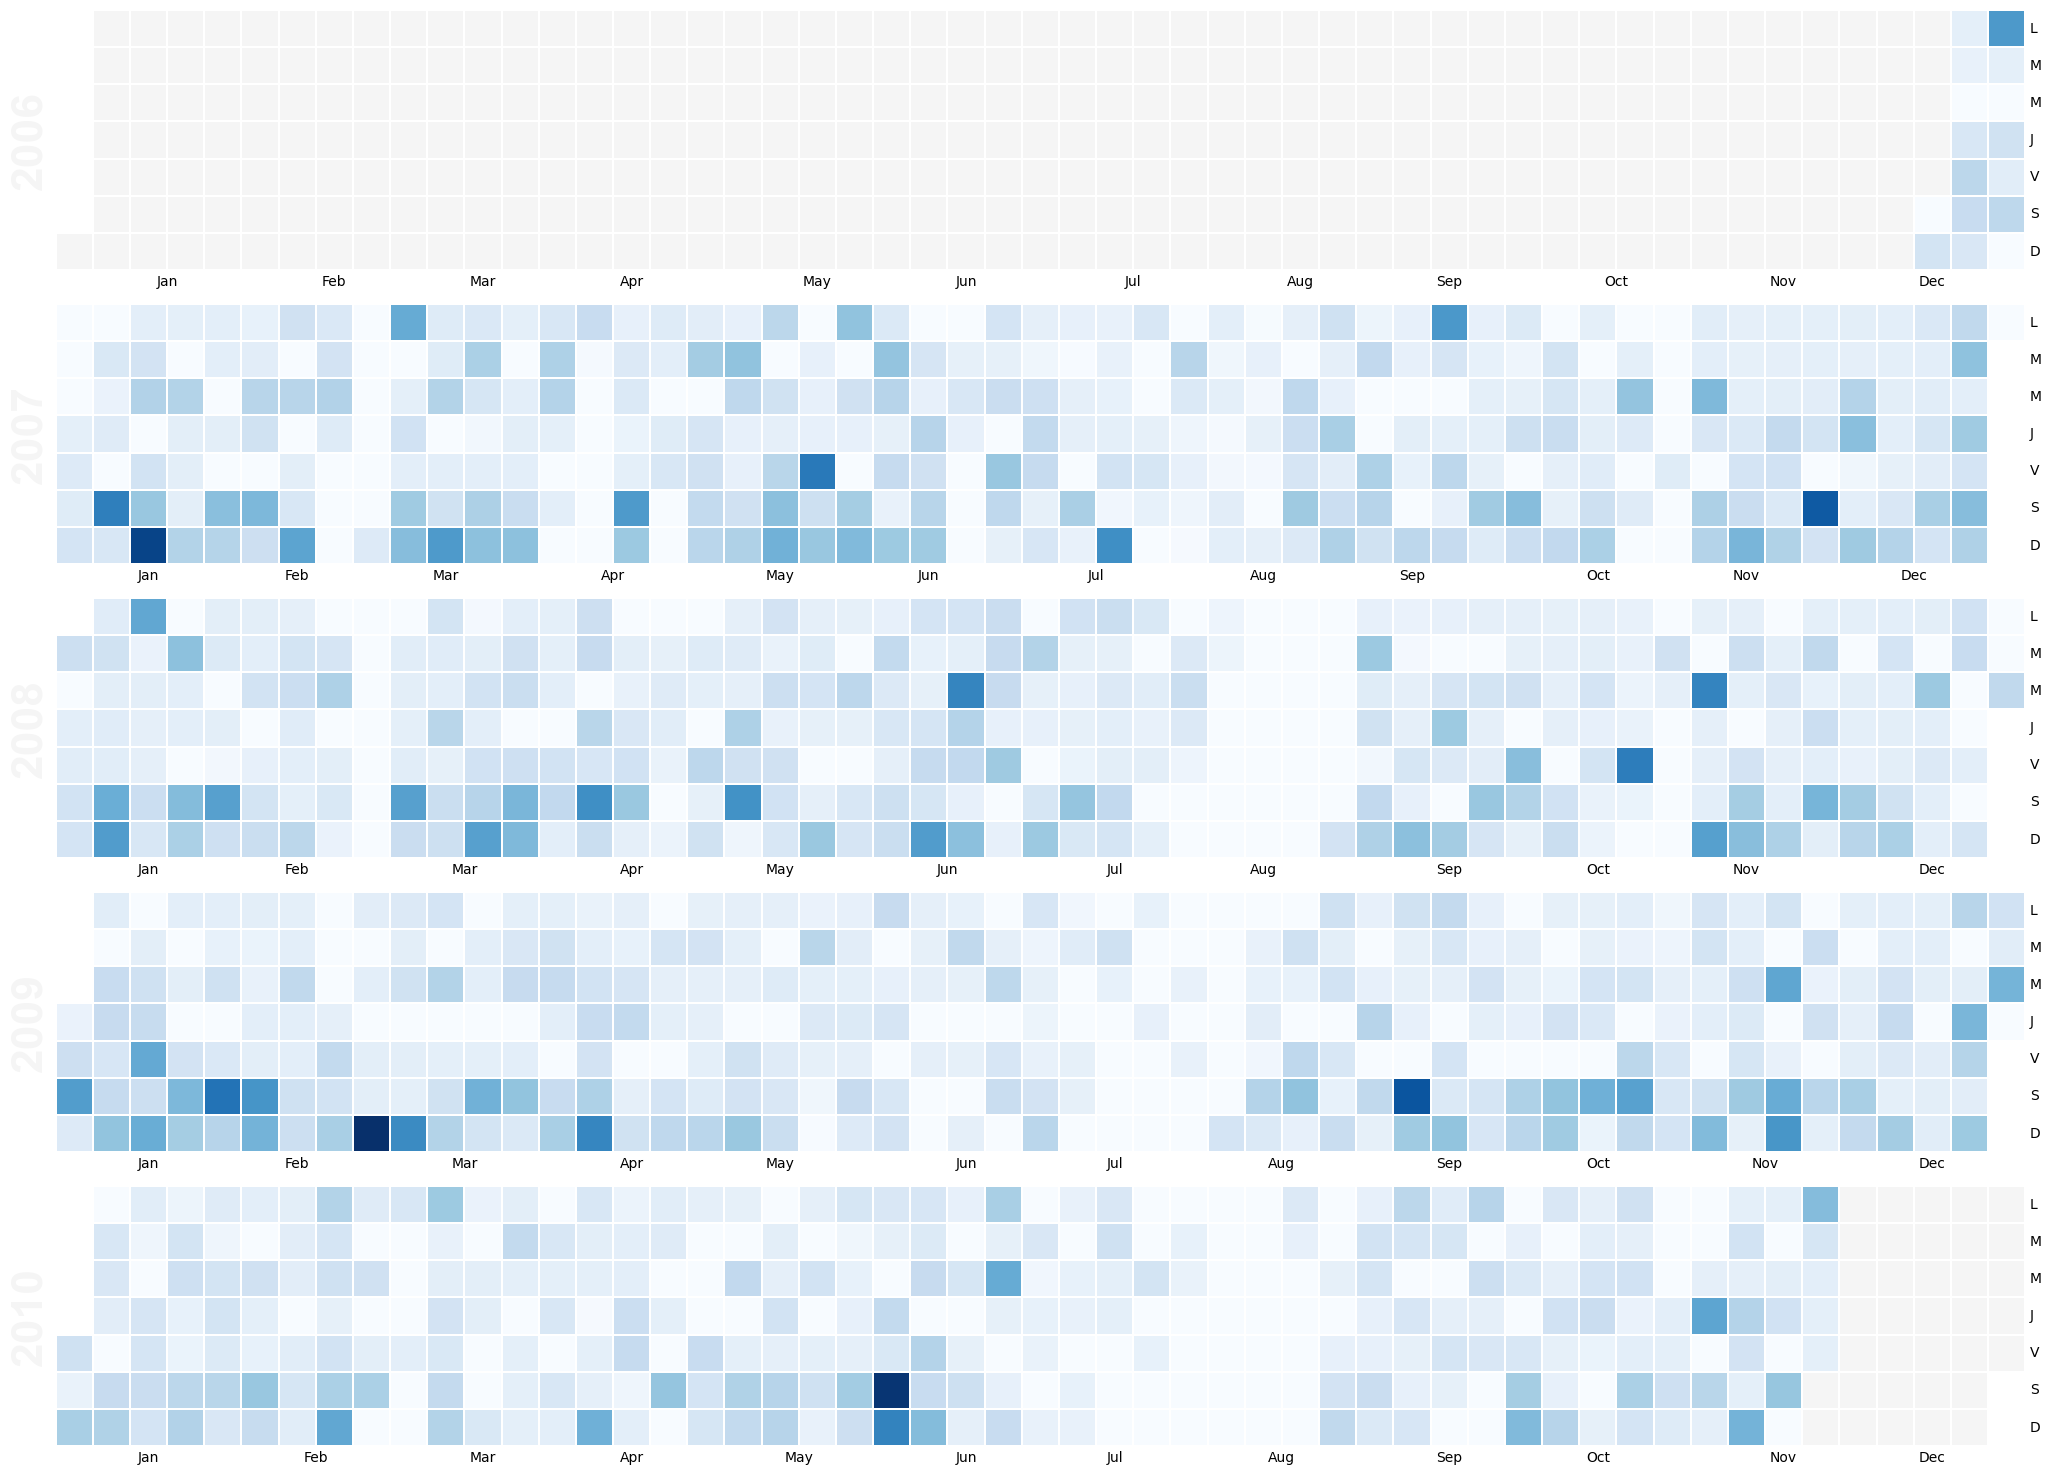

In [111]:
calmap.calendarplot(df['Sub_metering_1'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

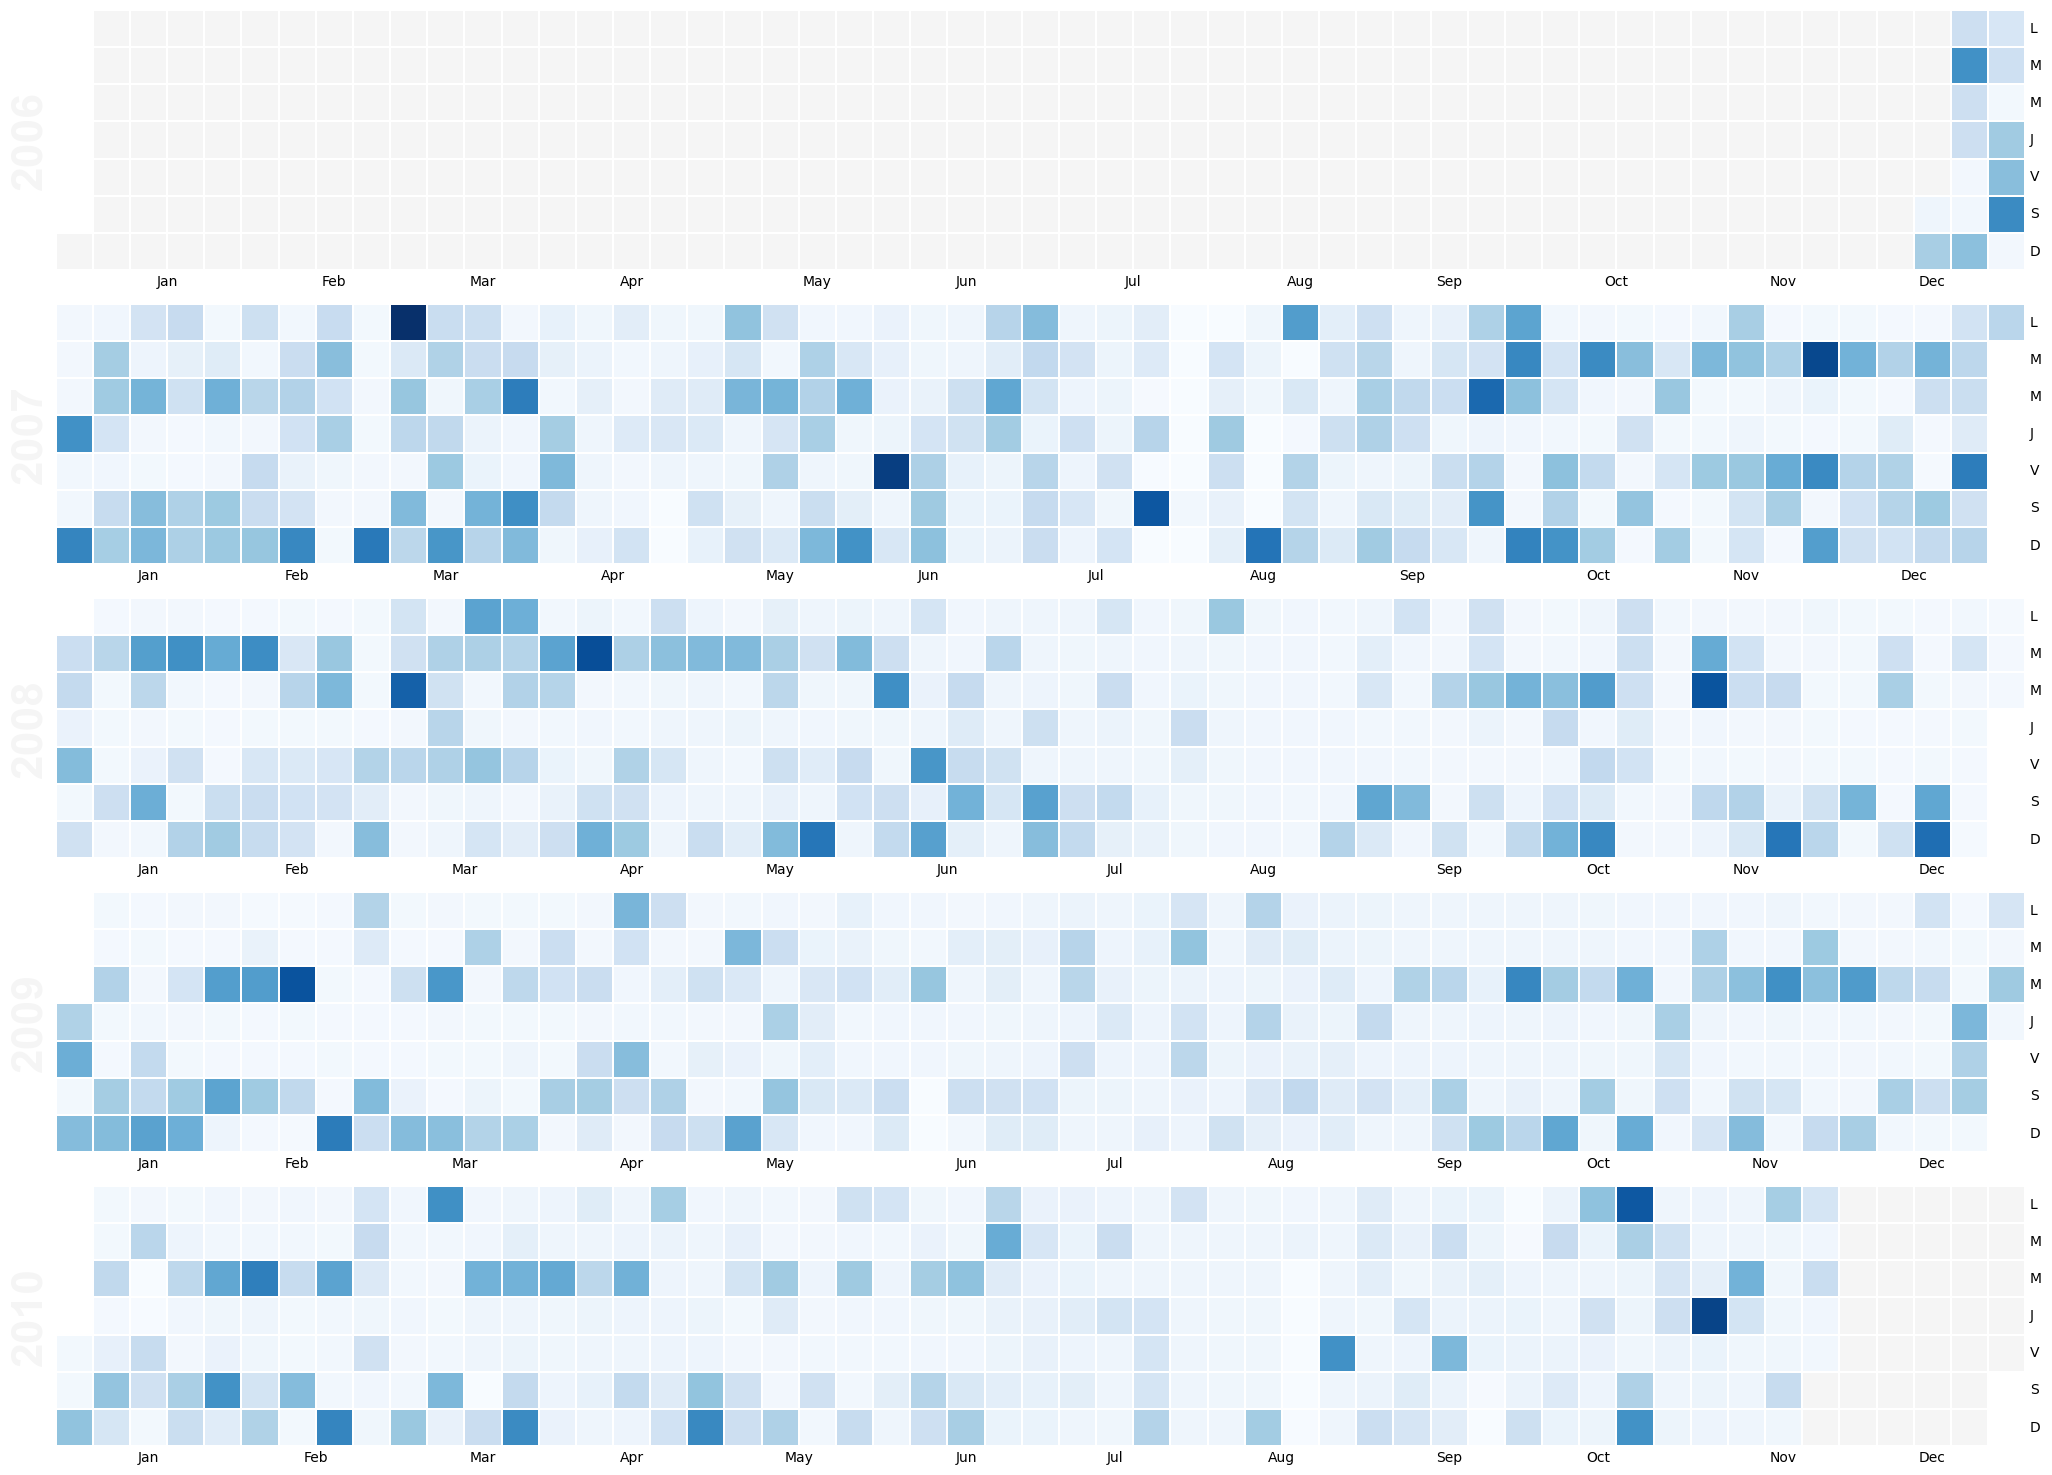

In [112]:
calmap.calendarplot(df['Sub_metering_2'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


Nous pouvons constater après avoir plot ce submetering 3 que la ville est particulièrement froide. L'été, il n'y a pas de climatisateur puisqu'il n'y a pas de consommation. En hiver et pendant les jours froids il y a une forte consommation d'éléctricité. Il s'agit d'une saisonnalité qui nous permettra d'anticiper la consommation des ménages dans les prochains jours. Par contre, l'introduction de la prévision météreologique serait très intéréssante afin de prévoir ce type de consommation. 

(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

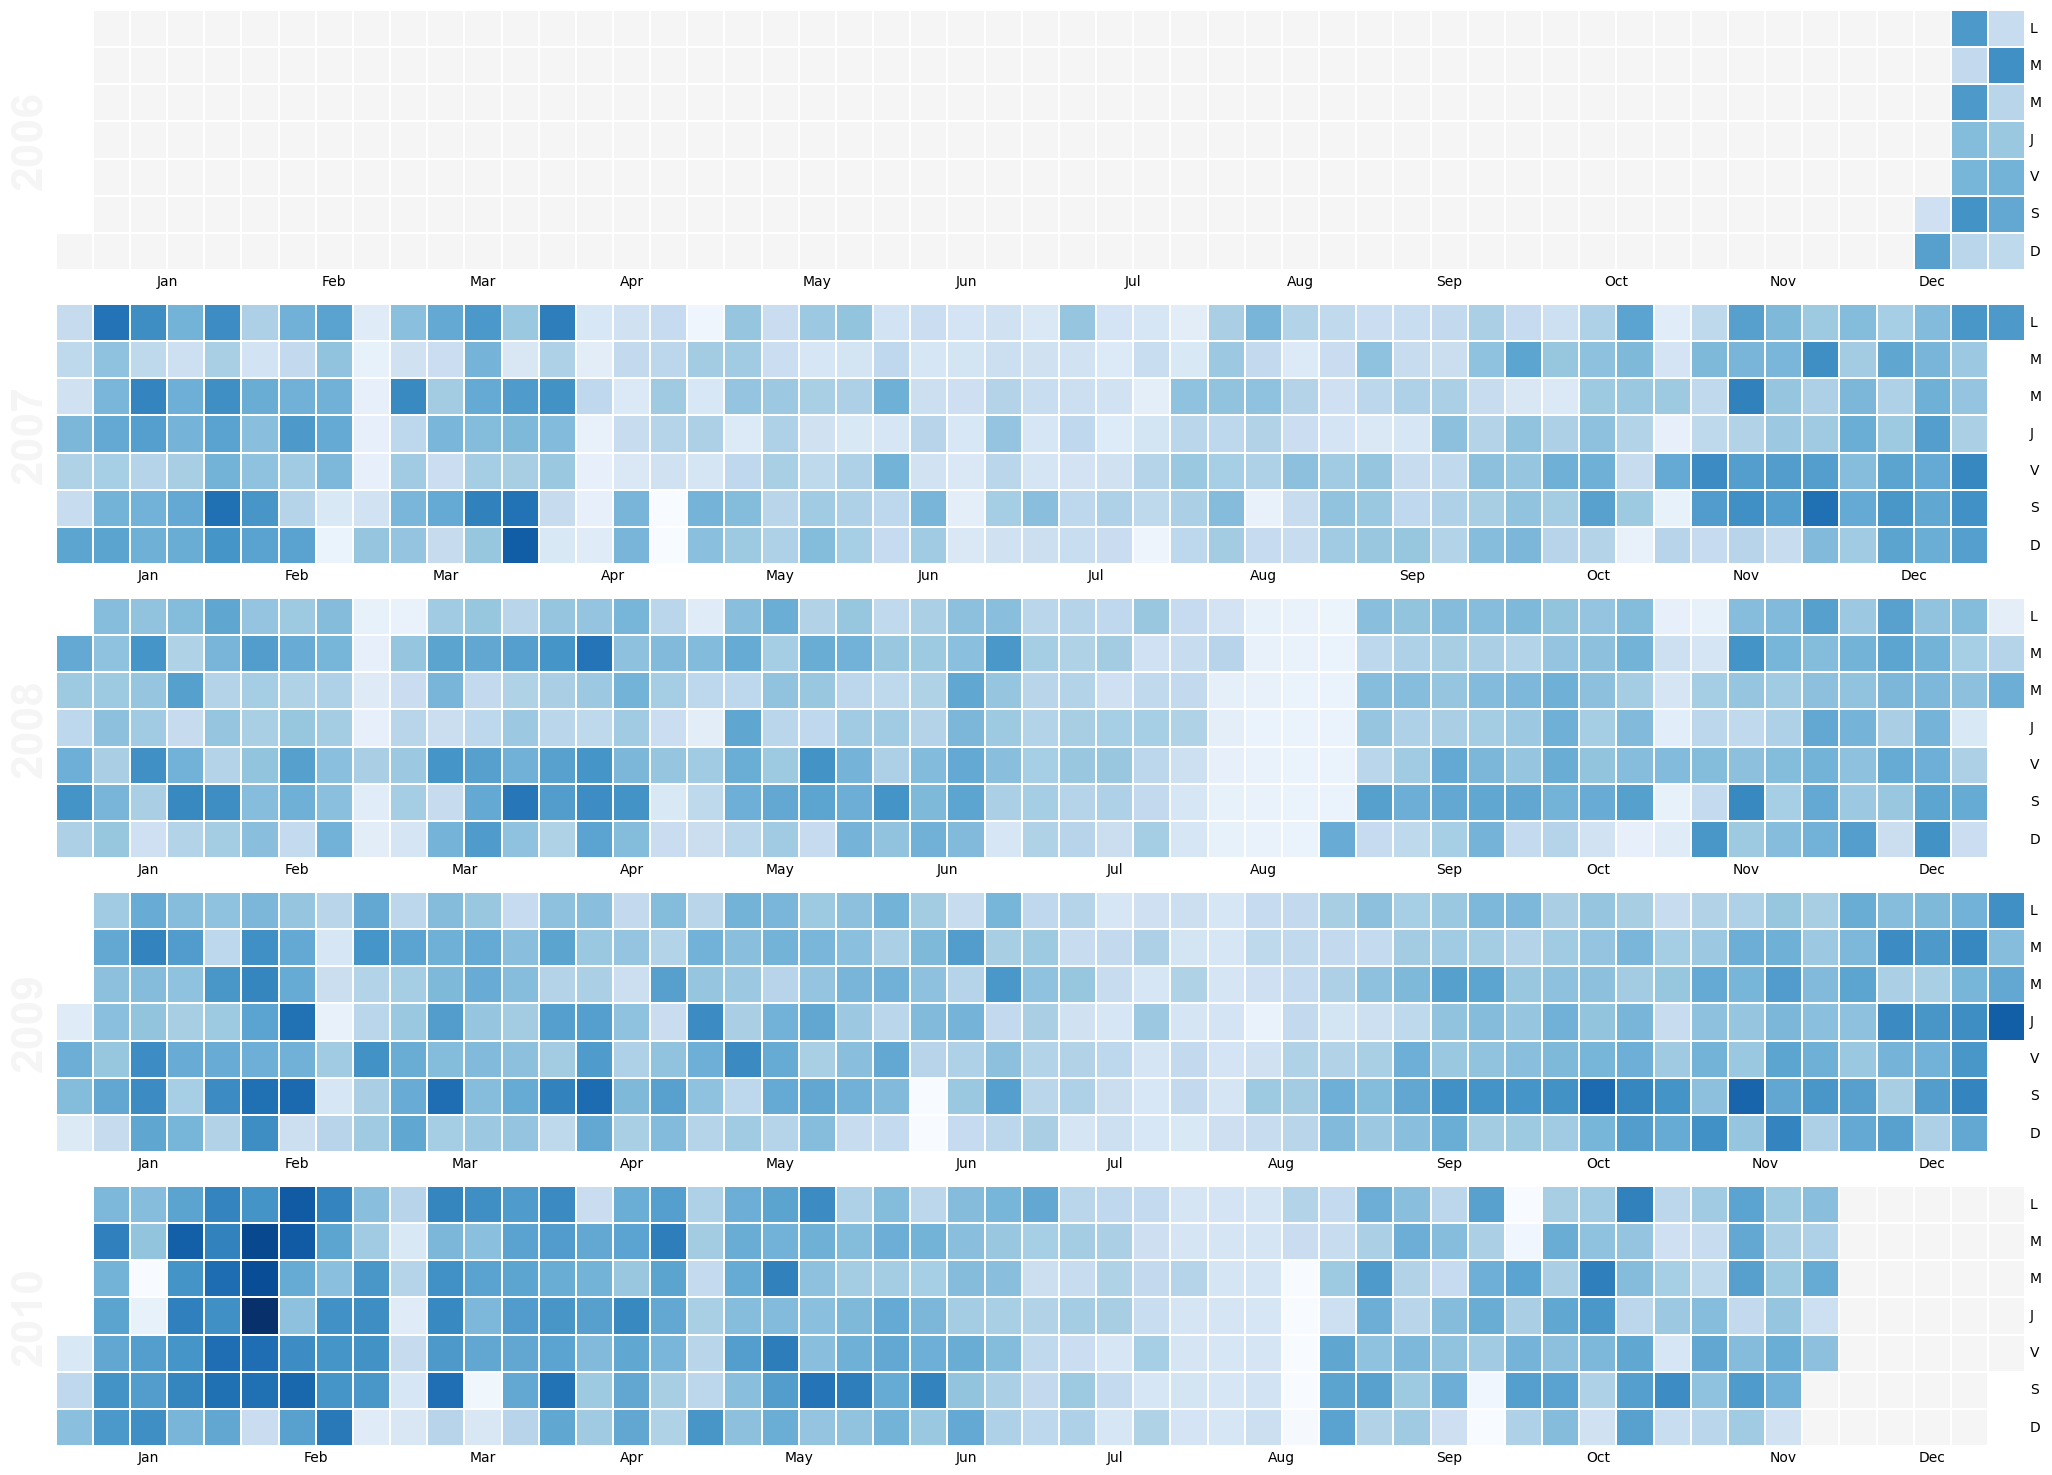

In [113]:
calmap.calendarplot(df['Sub_metering_3'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


(<Figure size 2400x1500 with 5 Axes>,
 array([<AxesSubplot: ylabel='2006'>, <AxesSubplot: ylabel='2007'>,
        <AxesSubplot: ylabel='2008'>, <AxesSubplot: ylabel='2009'>,
        <AxesSubplot: ylabel='2010'>], dtype=object))

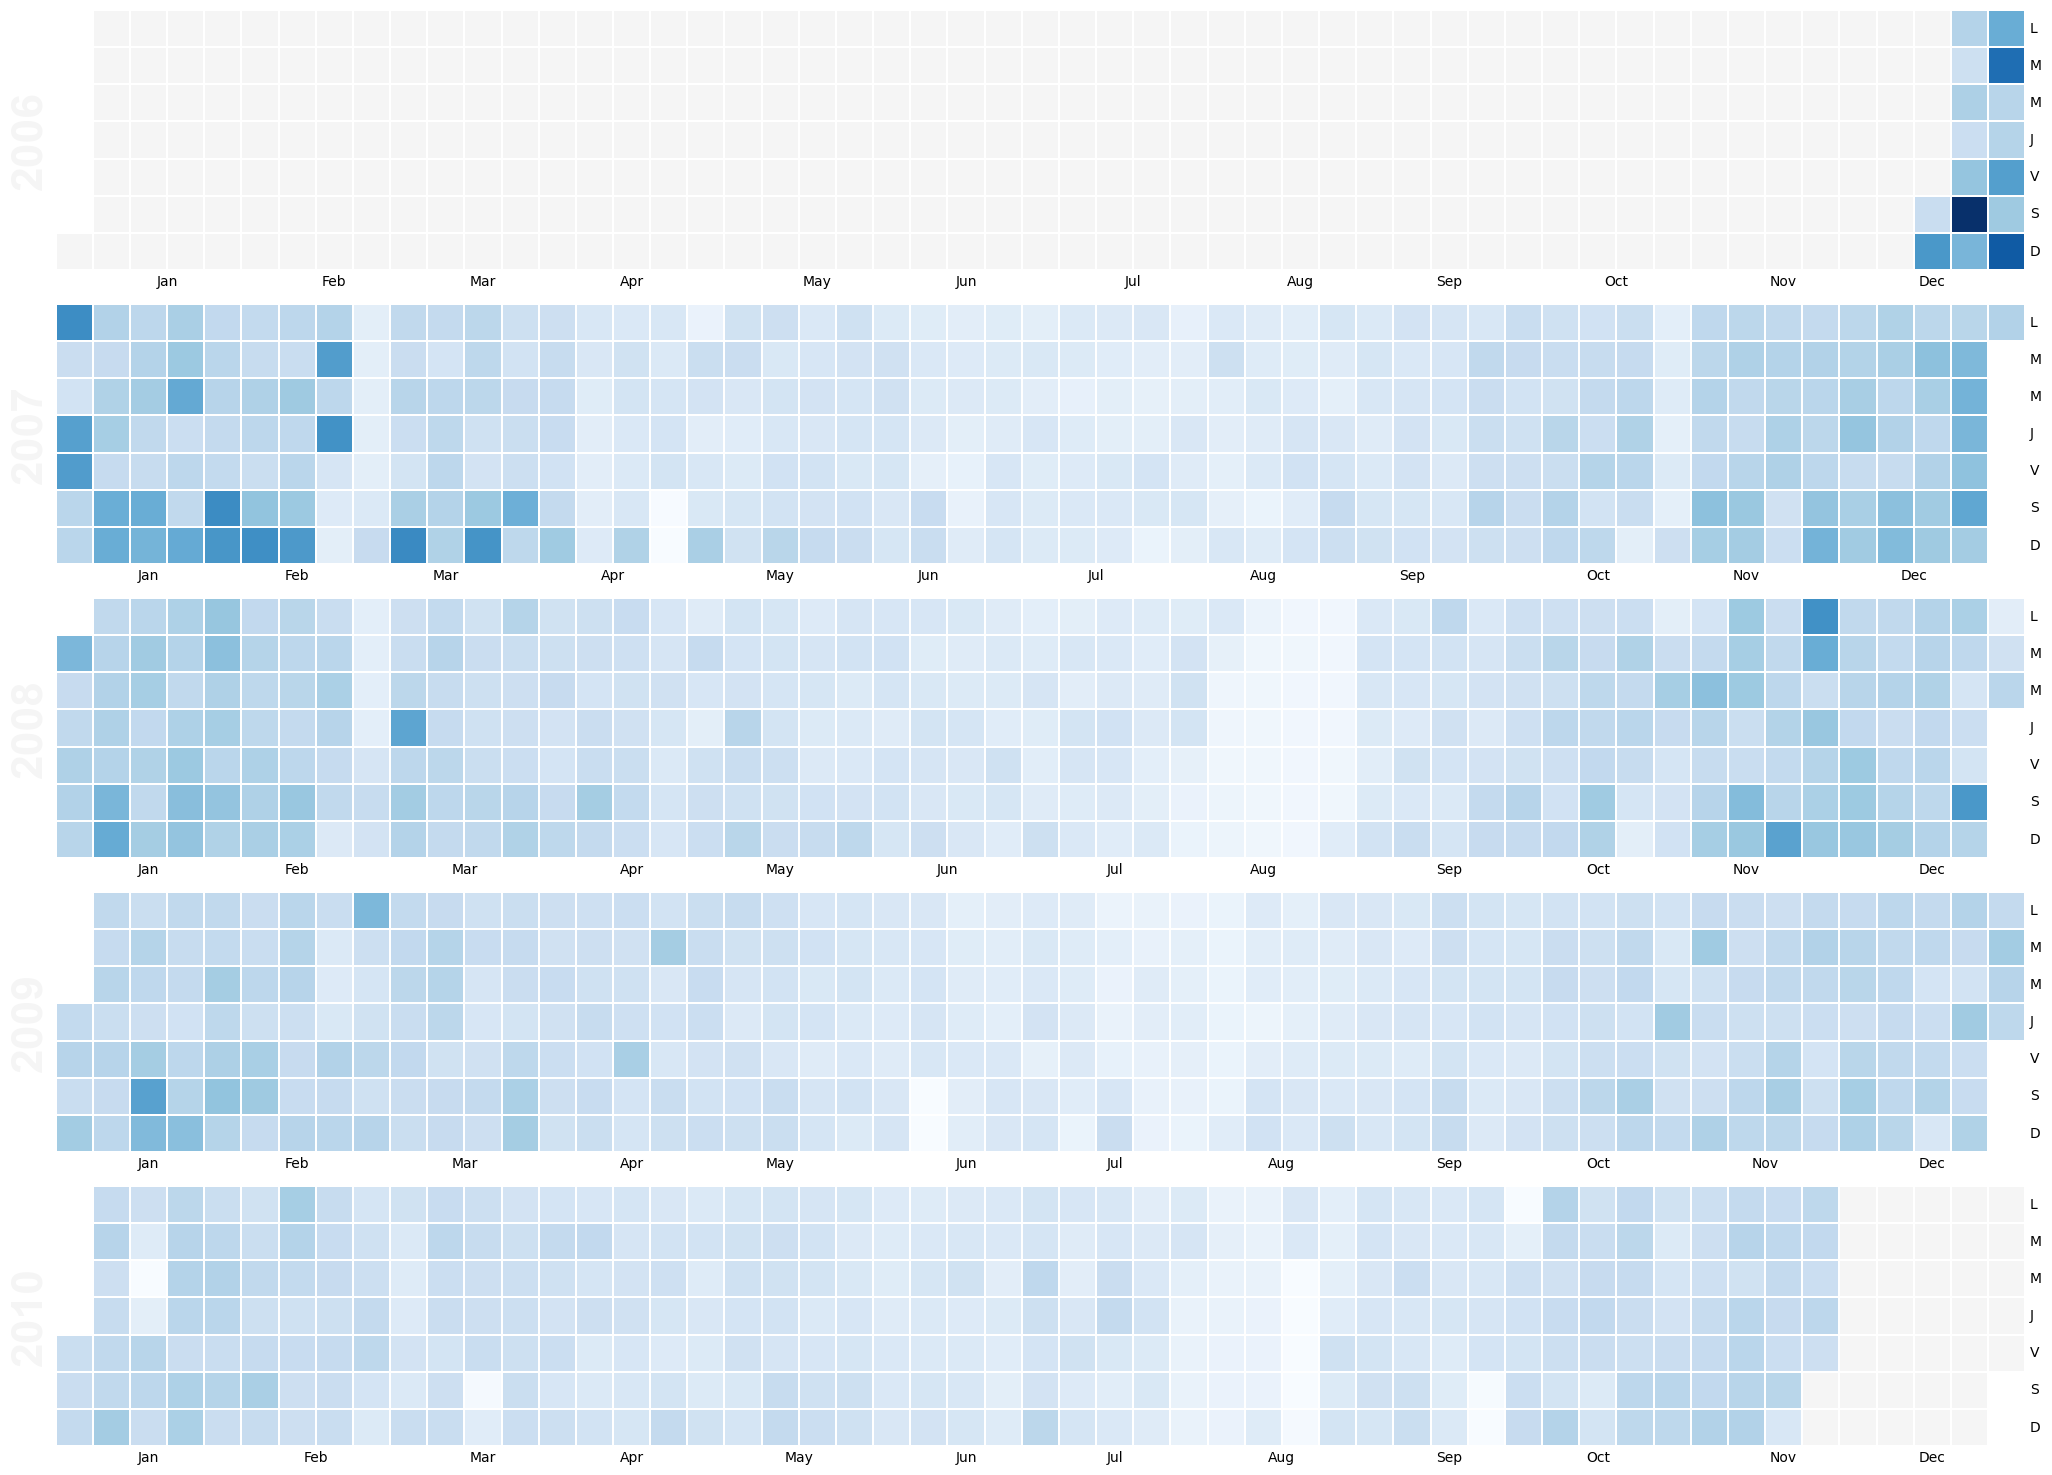

In [114]:
calmap.calendarplot(df['other_submetering'], monthticks=3, daylabels='LMMJVSD', cmap='Blues',
                    linewidth=0.2, fig_kws=dict(figsize=(24, 15)))


### Visualisation des time series

En examinant la consommation électrique sur une base trimestrielle avec la granularité la moins fine, nous pouvons constater que bien que la demande électrique globale soit très saisonnière, la consommation électrique de la cuisine et de la buanderie ne le sont pas. Toutefois, si nous examinons les données à la maille la plus fine, c'est-à-dire quotidiennement, toutes les consommations présentent une certaine saisonnalité. Cette saisonnalité pourra être prise en compte dans un futur modèle de prédiction par l'ajout de variables saisonnières telles qu'une variable binaire pour l'été ou une pour l'hiver. L'idée est que ces variables auront un poids dans le modèle qui nous permettra d'anticiper la consommation future.

In [115]:
# Suppression de la feature voltage et year pour observer les autres features
cols = list(df.columns)
viz_cols = [i for i in cols if i not in [
    'Date', 'Time', 'Voltage', 'year', 'day', 'month']]


> Plotting des times series

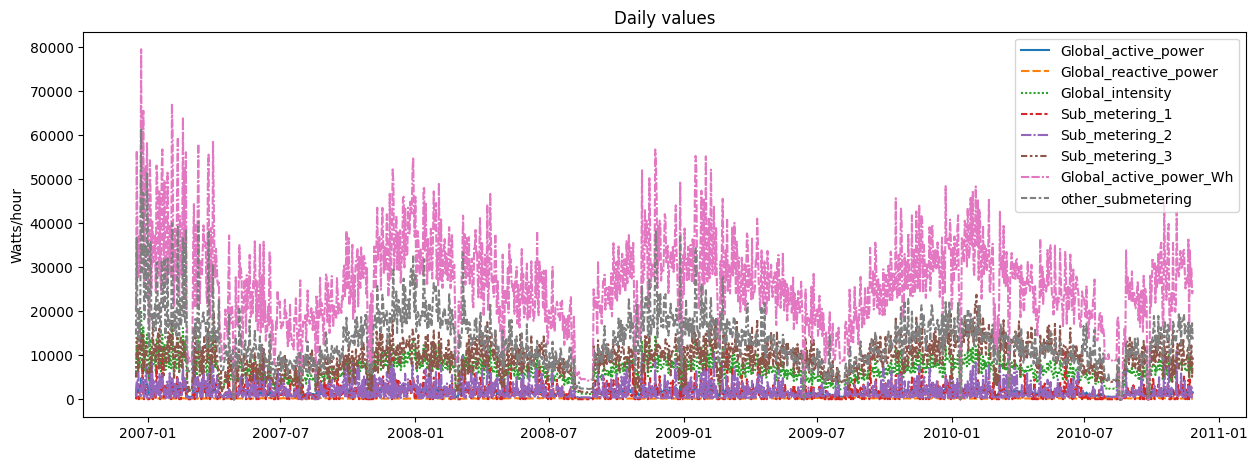

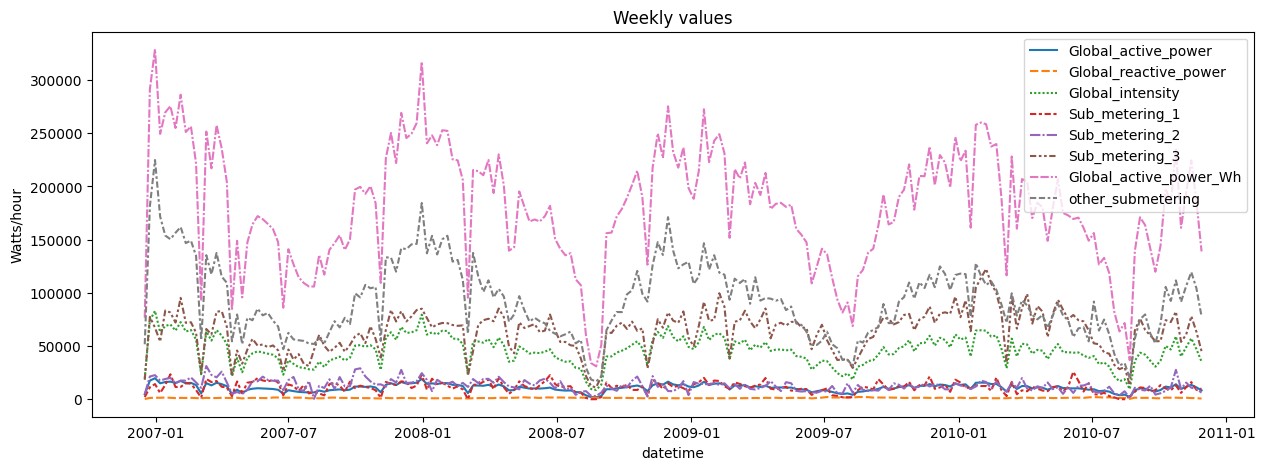

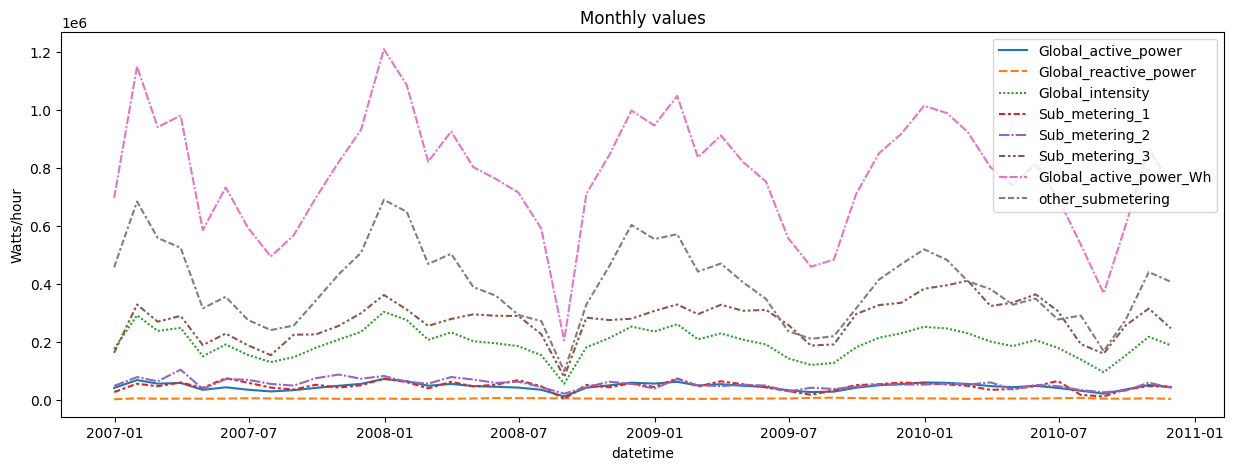

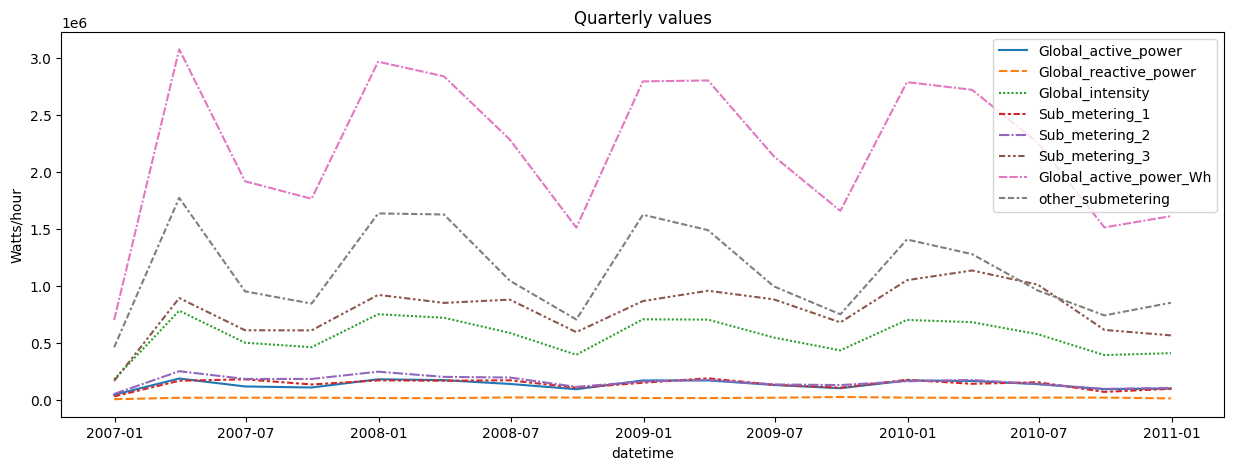

In [116]:
dataplots.plot_time_series(column=viz_cols, granularity="all")


> Distribution plots

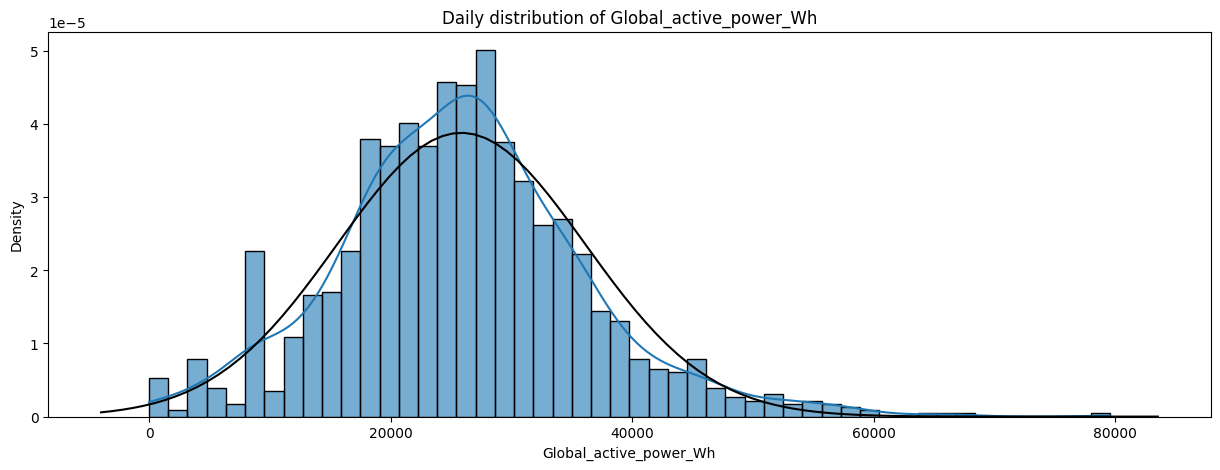

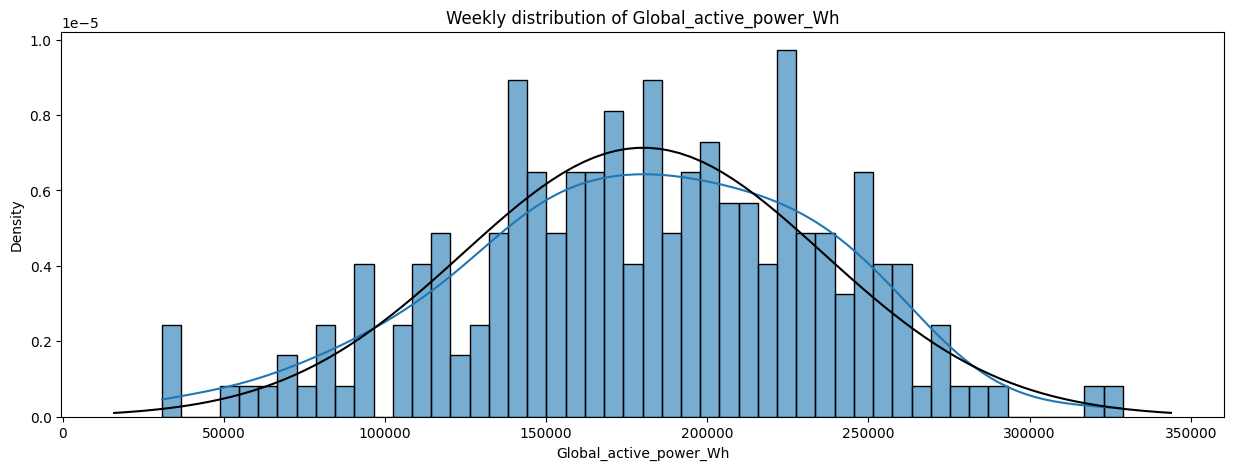

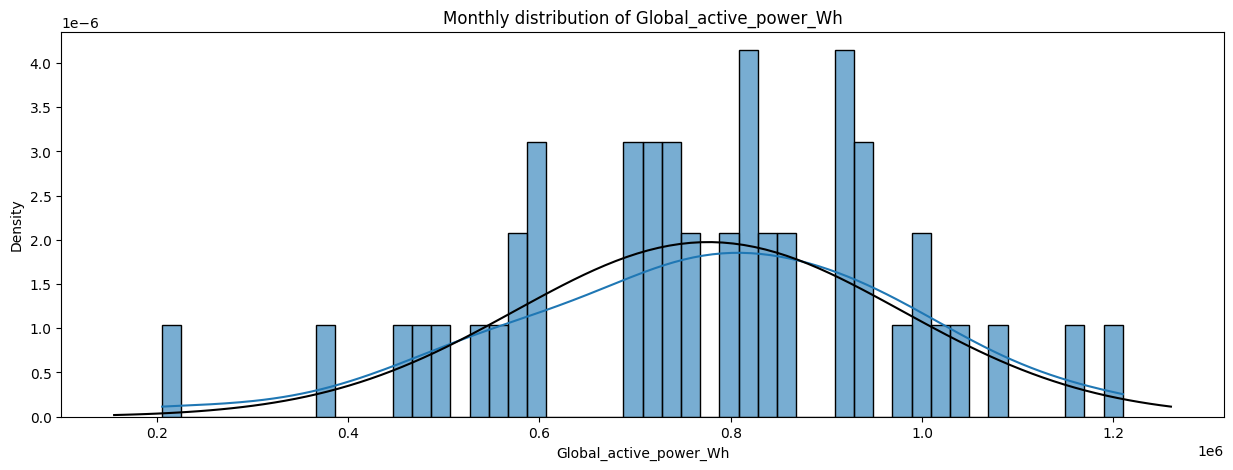

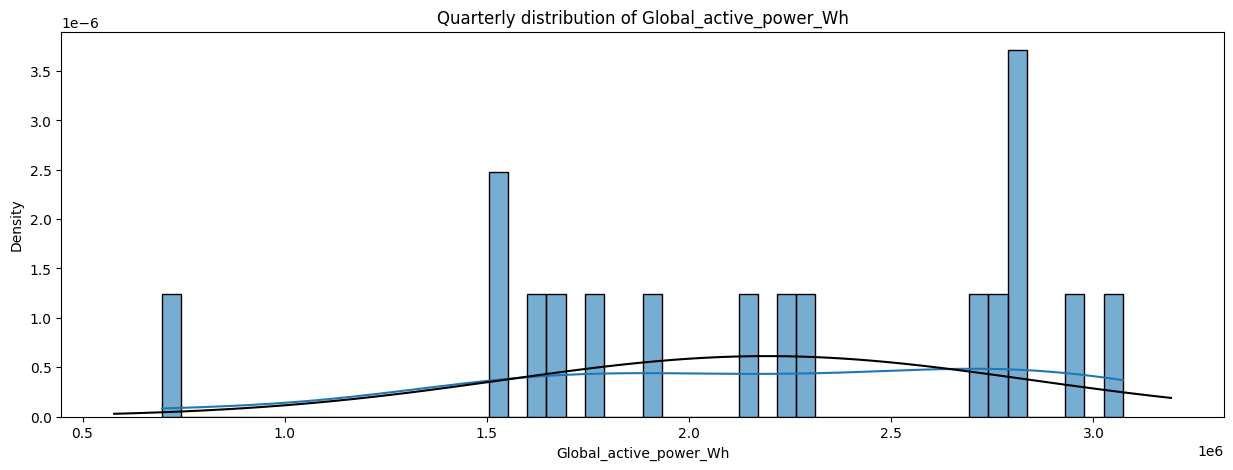

In [117]:
# Observation de la distribution de la puissance par rapport à une distribution Gaussienne
dataplots.plot_histogram(TARGET, granularity="all")


>  Pairplots

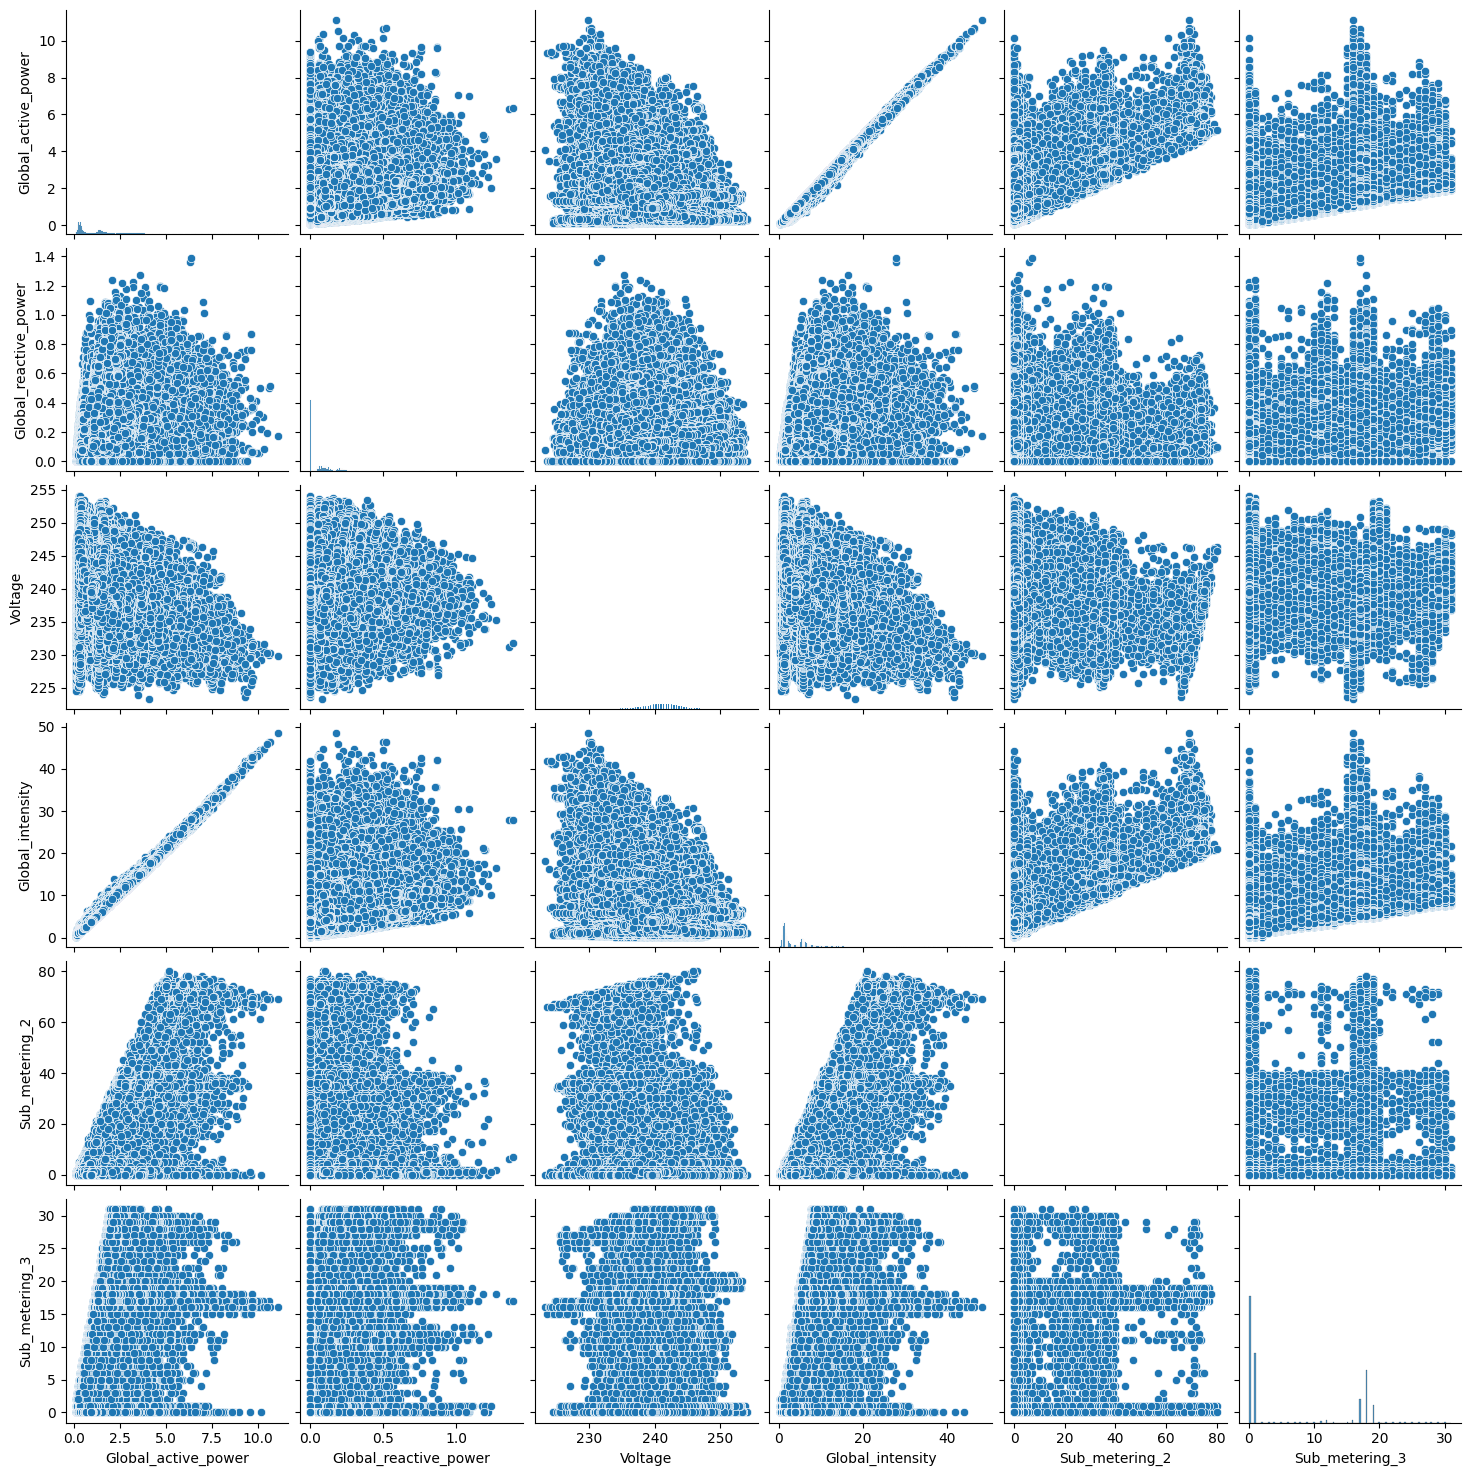

In [118]:
sns.pairplot(df[['Global_active_power', 'Global_reactive_power',
             'Voltage', 'Global_intensity', 'Sub_metering_2', 'Sub_metering_3']])


> Probability plots

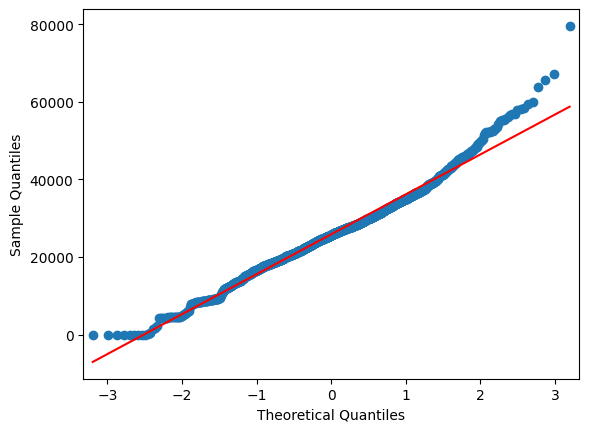

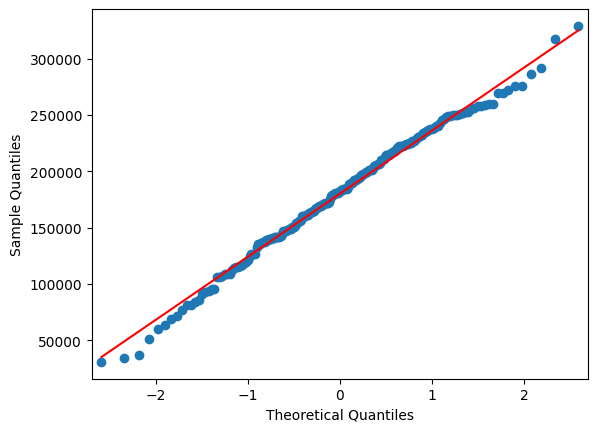

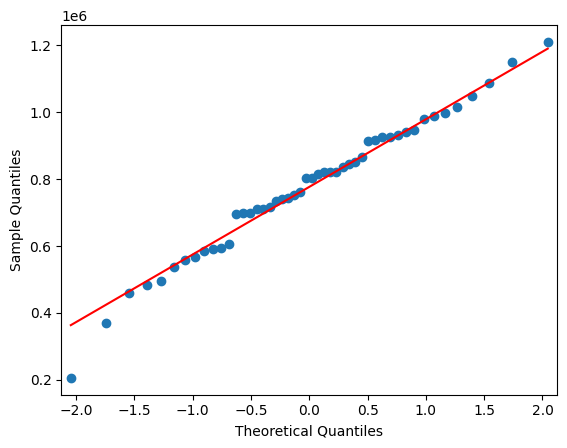

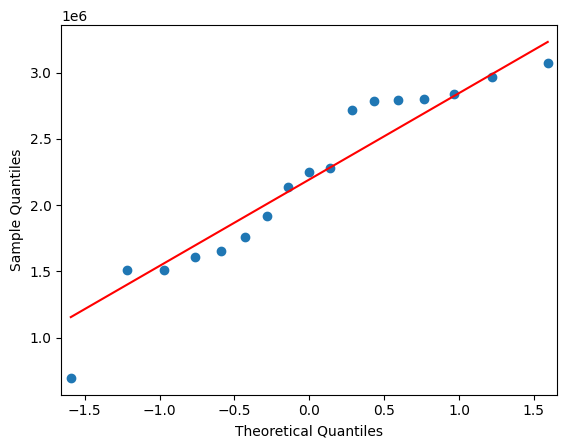

In [119]:
# Add probability plot for the column
dataplots.plot_prob(column=TARGET)


> Pattern analysis

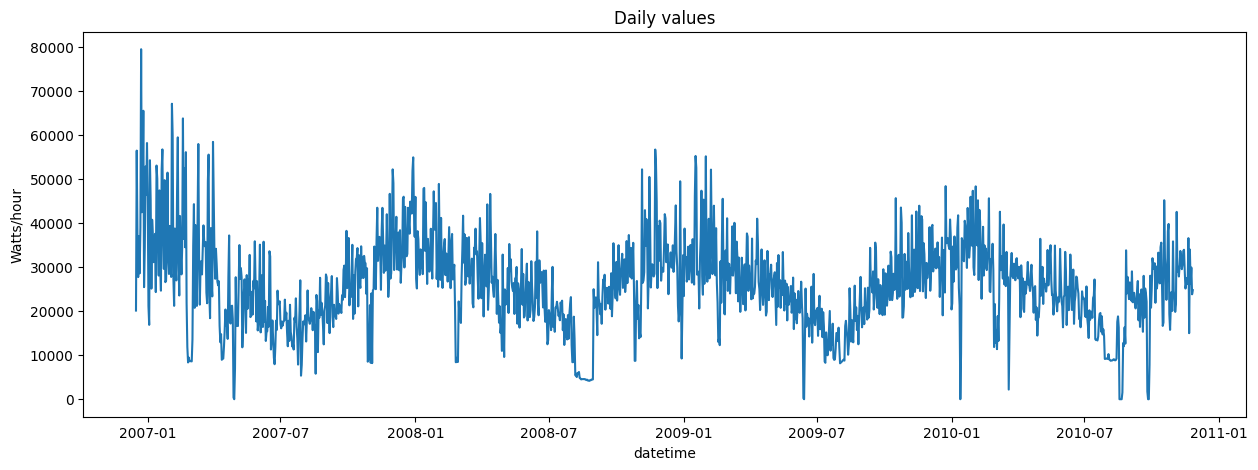

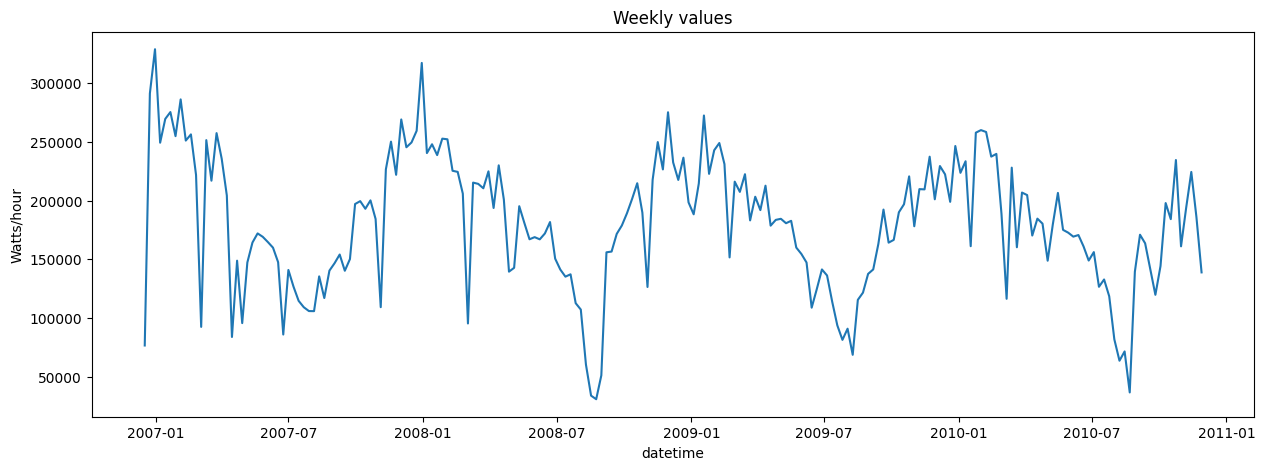

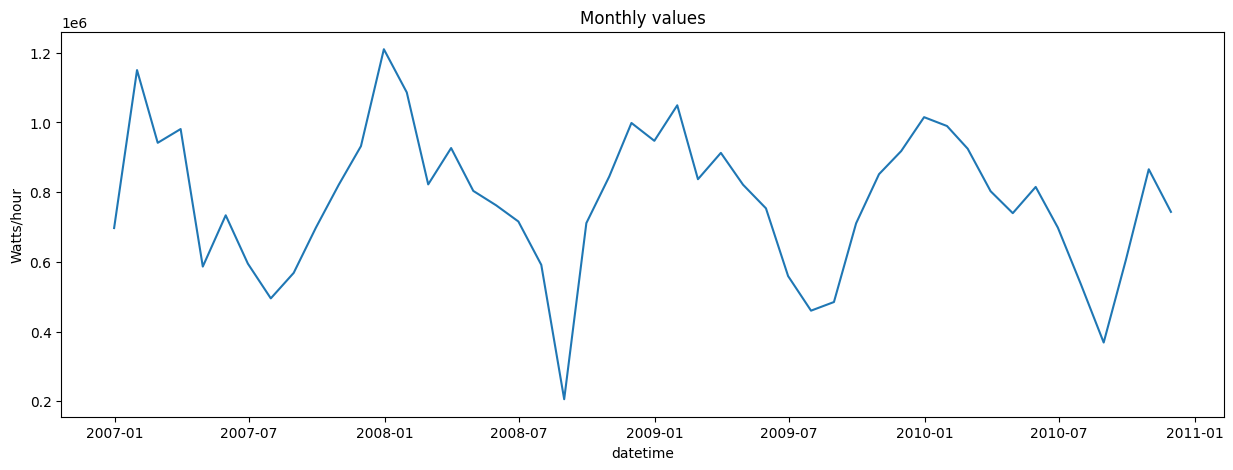

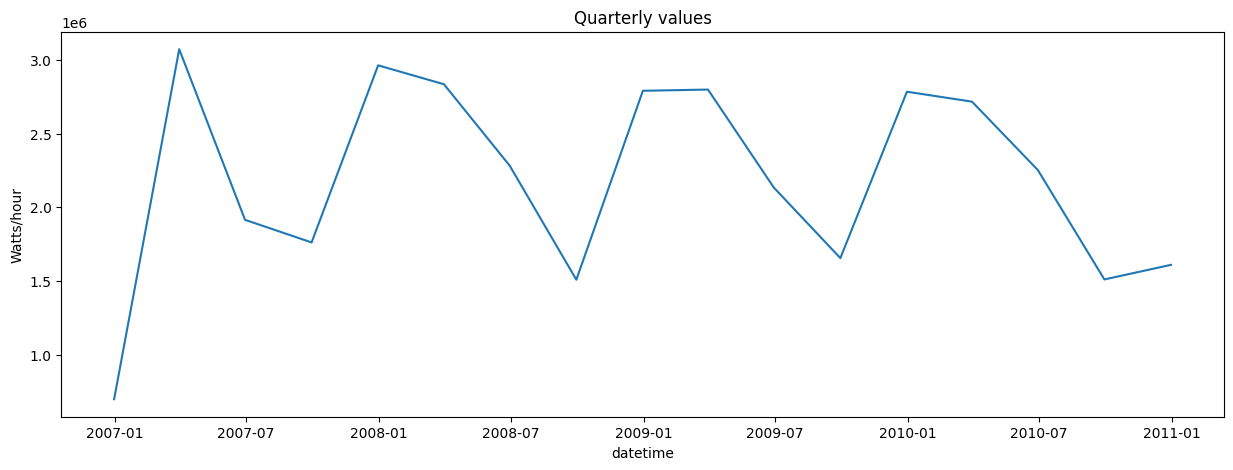

In [120]:
dataplots.plot_time_series(column=TARGET, granularity="all")


>  Breaking down the time variables to see patterns

In [121]:
from Plotter import PatternAnalyzer
analyzer = PatternAnalyzer(df)


In [122]:
sub_metering = ['Sub_metering_1', 'Sub_metering_2',
                'Sub_metering_3']


NameError: name 'index' is not defined

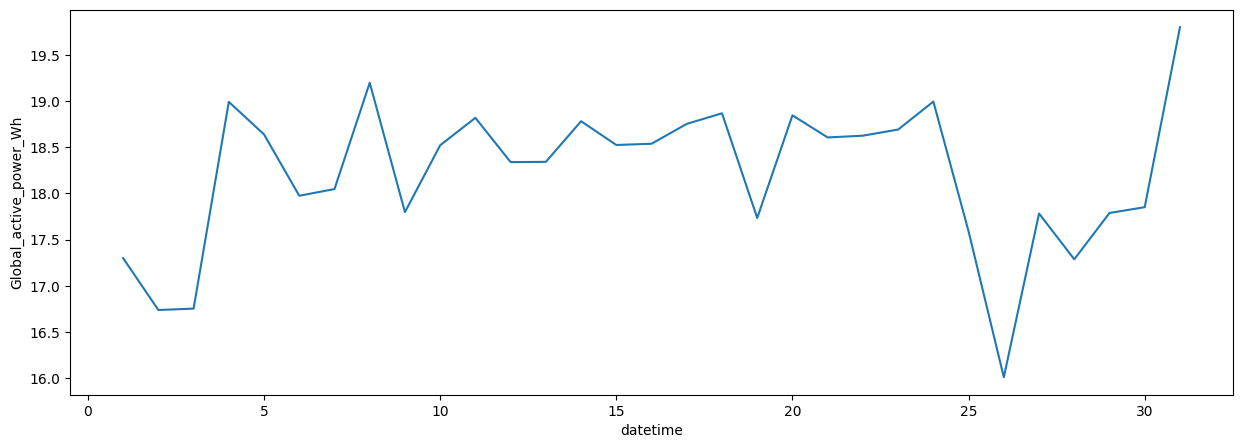

In [123]:
analyzer.plot_time_series(TARGET)


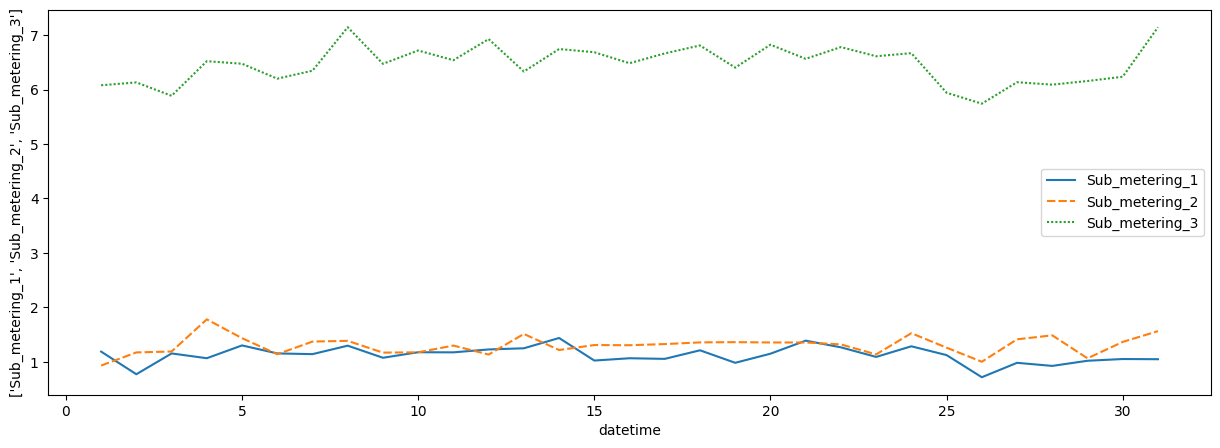

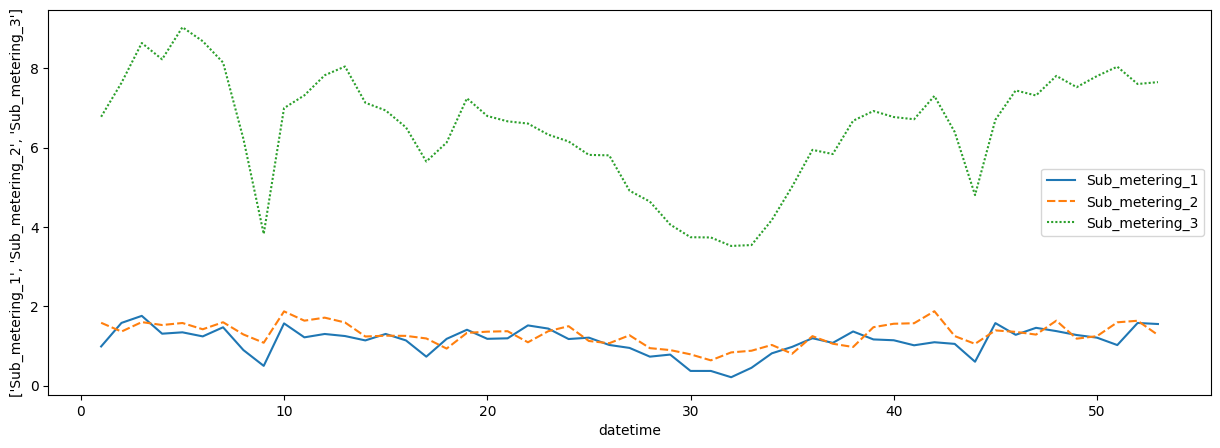

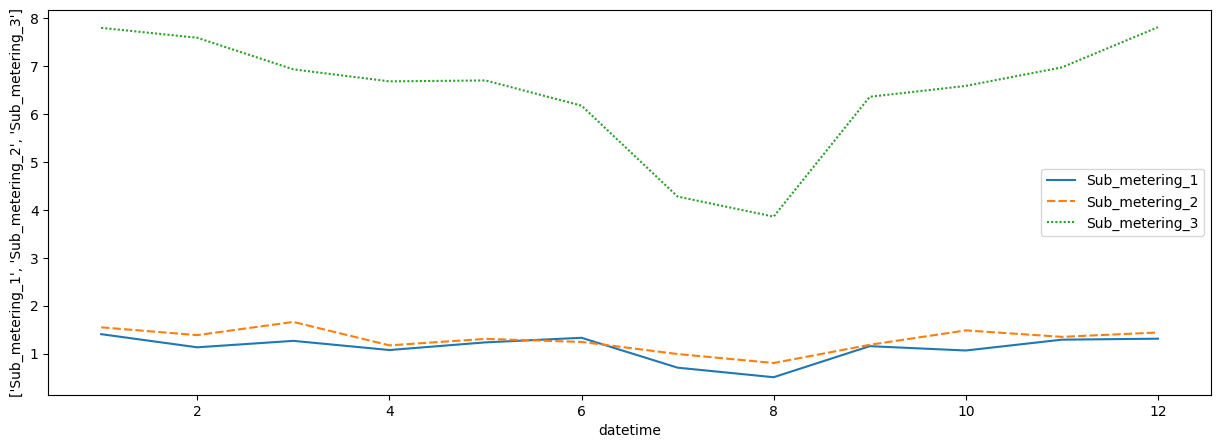

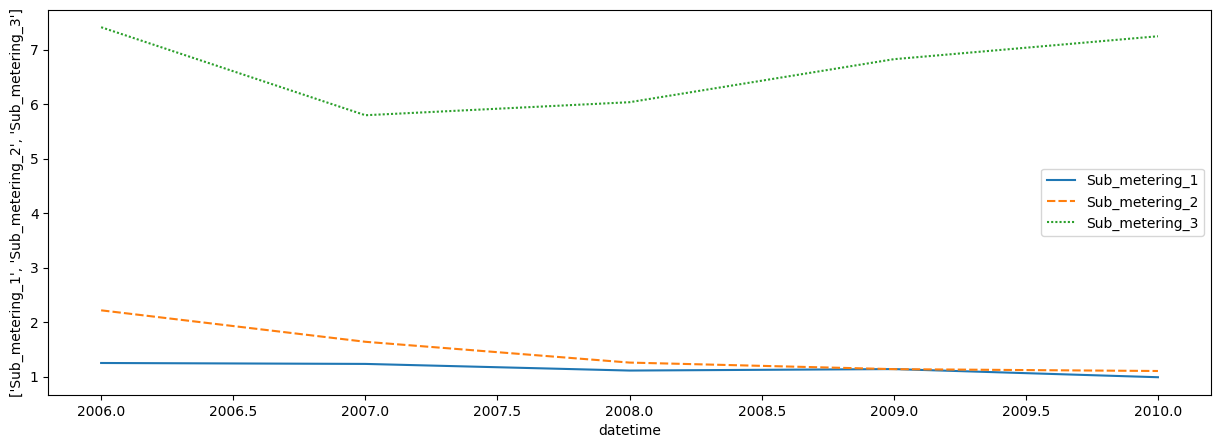

In [ ]:
analyzer.plot_time_series(sub_metering)


> Seasonal decomposition

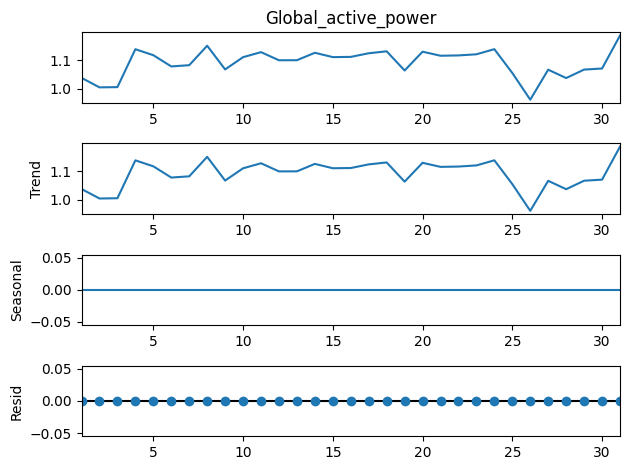

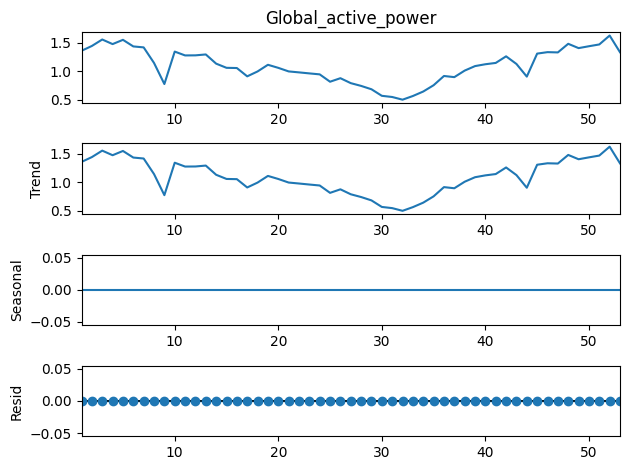

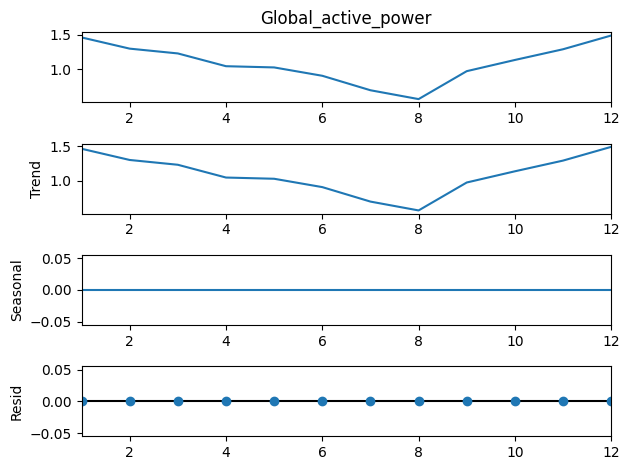

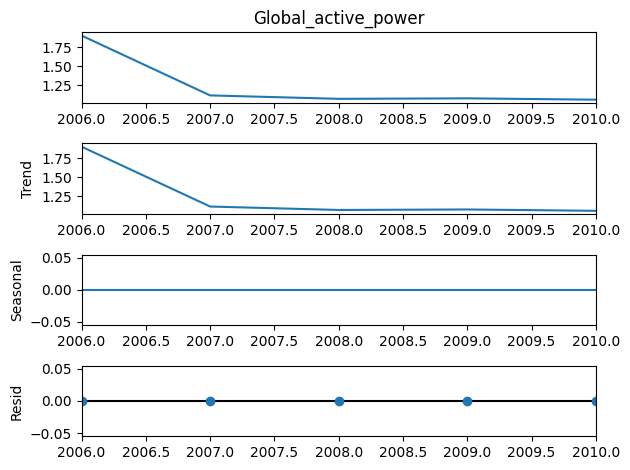

In [ ]:
analyzer.seasonal_decompositation_additive(TARGET)


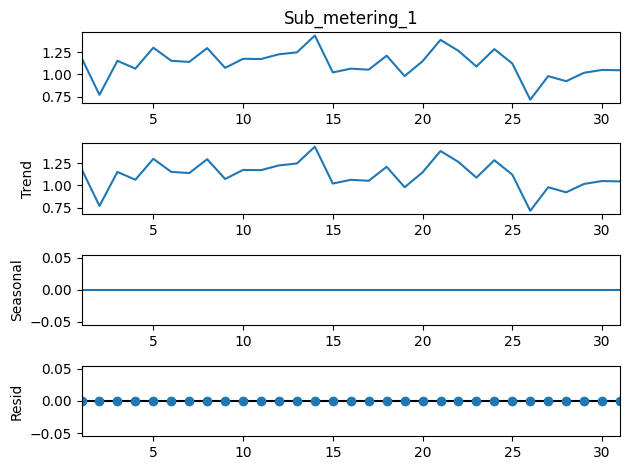

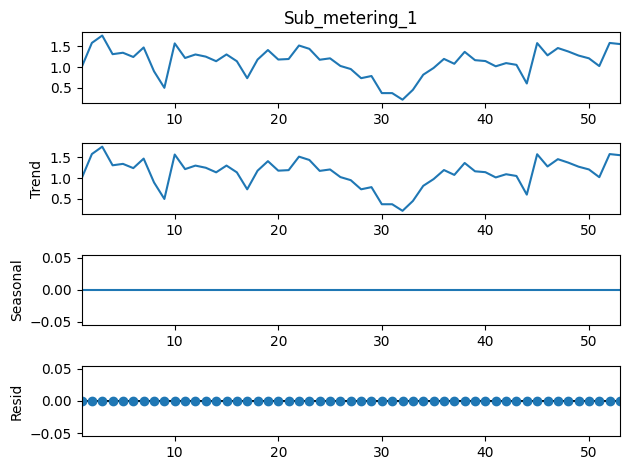

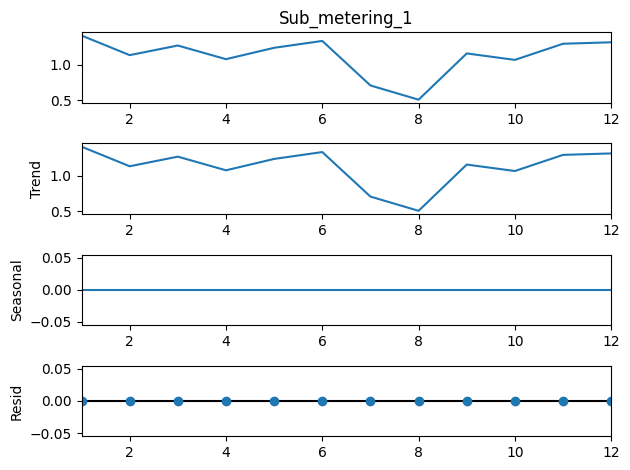

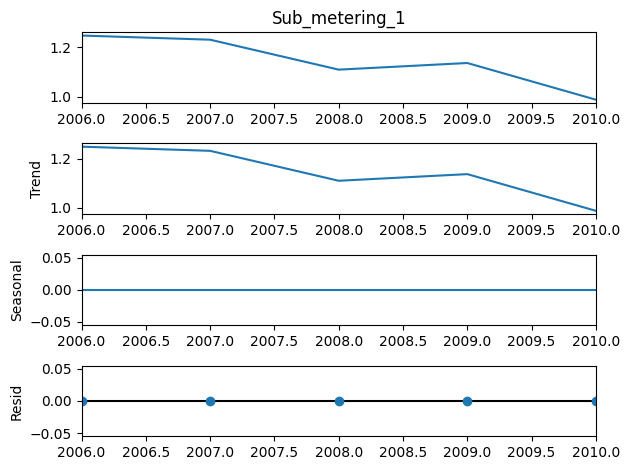

In [ ]:
analyzer.seasonal_decompositation_additive("Sub_metering_1")


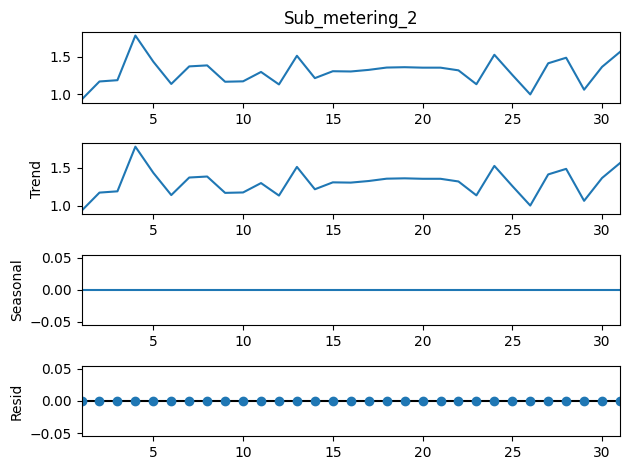

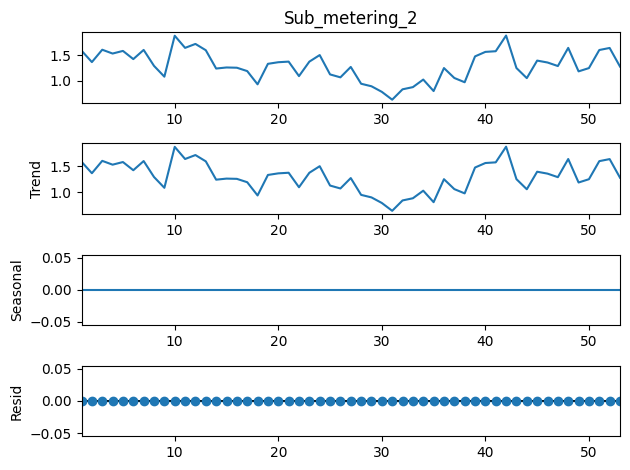

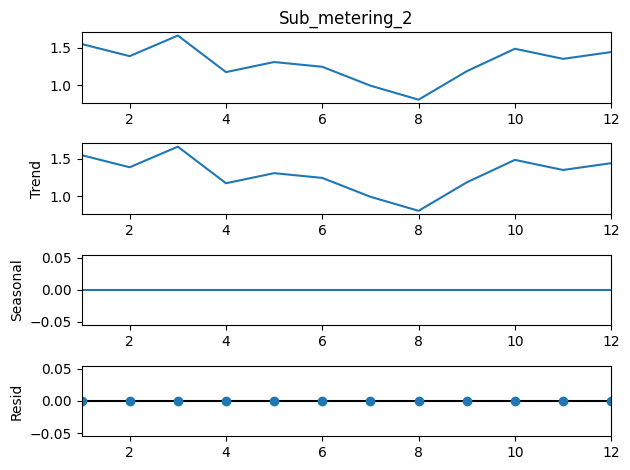

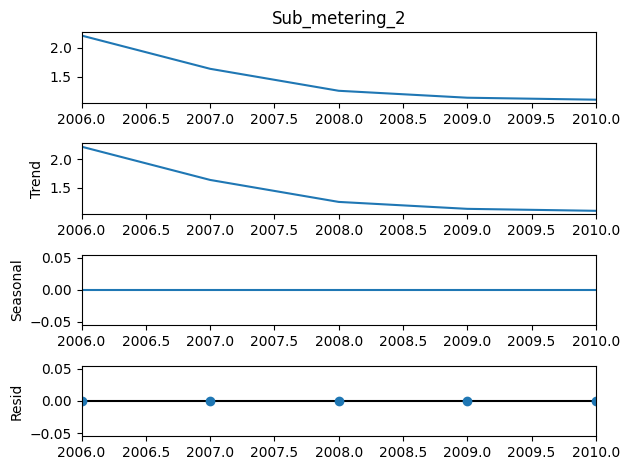

In [ ]:
analyzer.seasonal_decompositation_additive("Sub_metering_2")


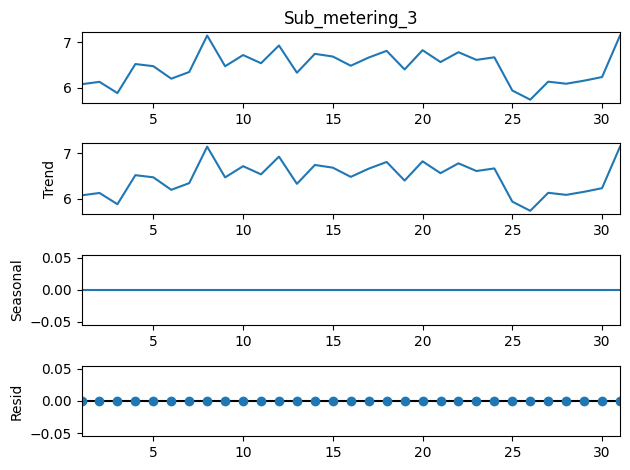

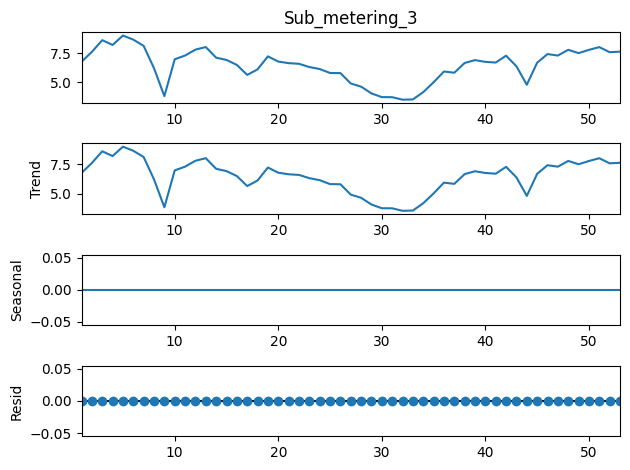

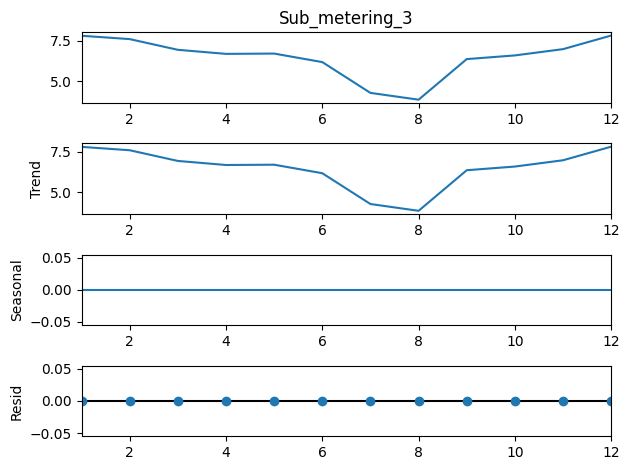

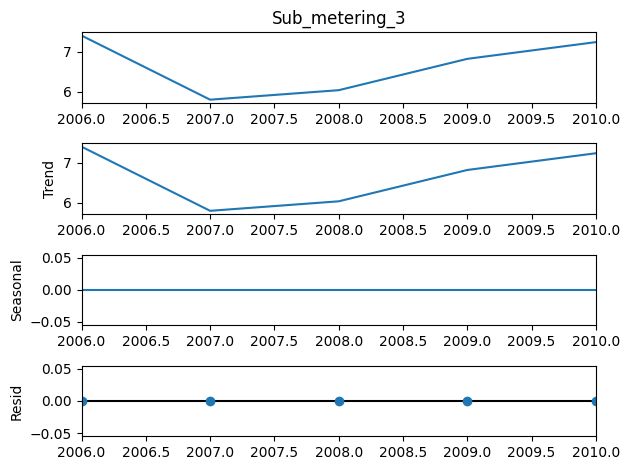

In [ ]:
analyzer.seasonal_decompositation_additive("Sub_metering_3")


## 4. Data cleaning et imputation de données manquantes (si nécessaire)

In [ ]:
# Nous avons des nan dans toutes les colonnes sauf la date
df.isna().any()

Date                     False
Time                     False
Global_active_power       True
Global_reactive_power     True
Voltage                   True
Global_intensity          True
Sub_metering_1            True
Sub_metering_2            True
Sub_metering_3            True
day                      False
month                    False
year                     False
dtype: bool

In [ ]:
# On vérifie si c'est bien toute la ligne qui est nan et c'est bien le cas.
mask = df['Global_active_power_Wh'].isna()
df.loc[~mask].isna().any()

Date                     False
Time                     False
Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
Sub_metering_3           False
day                      False
month                    False
year                     False
dtype: bool

In [ ]:
print("Comptage des NaN par colonne:")
print(df.isna().sum())

# Si bien cela peut paraître beaucoup, cela ne réprésente que 1,25% des observations.

Comptage des NaN par colonne:
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
day                          0
month                        0
year                         0
dtype: int64


In [ ]:
print(f'Nombre de jours qui présentent des NaN: {df[df["Global_active_power_Wh"].isna()]["Date"].nunique()}')

Nombre de jours qui présentent des NaN: 82


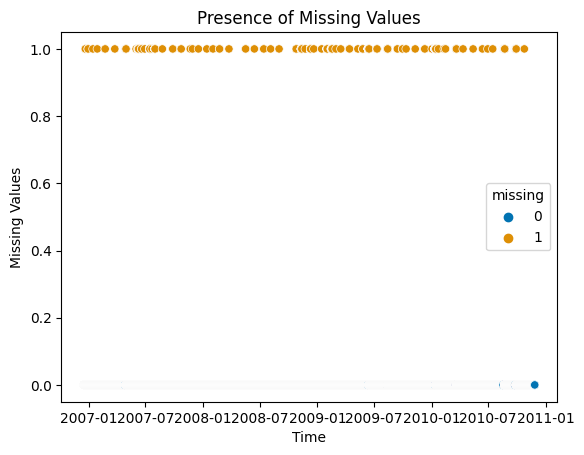

In [ ]:
# Regardons la distribution des NaN, si c'est une distribution plutôt aléatoire on peut dropper les nan.
df['missing'] = 0
mask = df['Global_active_power_Wh'].isna()
df.loc[mask, 'missing'] = 1 

# Create a scatter plot with color-coded markers
sns.scatterplot(data=df, x=df.index, y='missing', hue='missing', palette='colorblind', marker='o')

# Set the axis labels and title
plt.xlabel('Time')
plt.ylabel('Missing Values')
plt.title('Presence of Missing Values')

# Show the plot
plt.show()

# La distribution peut être considéré comme aléatoire en dates il s'agit des jours on le compteur ne marche pas ou présente une défaillance


In [ ]:
# En conséquence, il est justifié de drop les valeurs manquantes
df.dropna(inplace=True)

## 5. Feature engineering en expliquant votre démarche et les variables créées

>  Creating variables

In [ ]:
featureeng = FeatureEngineer()

In [ ]:
# Create rolling window features
window_sizes = [5, 30, 60]
for window in window_sizes:
    df[f'Global_active_power_mean_{window}'] = df['Global_active_power'].rolling(
        window).mean()
    df[f'Global_active_power_min_{window}'] = df['Global_active_power'].rolling(
        window).min()
    df[f'Global_active_power_max_{window}'] = df['Global_active_power'].rolling(
        window).max()
    df[f'Global_active_power_std_{window}'] = df['Global_active_power'].rolling(
        window).std()


In [ ]:
# Create time-based features
df['hour'] = df.index.hour
df['is_daytime'] = np.where(df['hour'].isin(range(7, 20)), 1, 0)


In [ ]:
# Apply Fourier Transform
fft_vals = fft(df['Global_active_power'])
abs_fft_vals = np.abs(fft_vals)
num_samples = len(df)
freqs = np.arange(num_samples) / num_samples
top_freqs = freqs[np.argsort(-abs_fft_vals)[:5]]

# Create Fourier Transform features
for i, freq in enumerate(top_freqs, 1):
    df[f'Global_active_power_freq_{i}'] = abs_fft_vals[int(freq*num_samples)]


In [ ]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'day', 'month', 'year', 'Global_active_power_lag_30',
       'Global_reactive_power_lag_30', 'Voltage_lag_30',
       'Global_intensity_lag_30', 'Sub_metering_1_lag_30',
       'Sub_metering_2_lag_30', 'Sub_metering_3_lag_30',
       'Global_active_power_lag_60', 'Global_reactive_power_lag_60',
       'Voltage_lag_60', 'Global_intensity_lag_60', 'Sub_metering_1_lag_60',
       'Sub_metering_2_lag_60', 'Sub_metering_3_lag_60',
       'Global_active_power_lag_120', 'Global_reactive_power_lag_120',
       'Voltage_lag_120', 'Global_intensity_lag_120', 'Sub_metering_1_lag_120',
       'Sub_metering_2_lag_120', 'Sub_metering_3_lag_120',
       'Global_active_power_lag_1440', 'Global_reactive_power_lag_1440',
       'Voltage_lag_1440', 'Global_intensity_lag_1440',
       'Sub_metering_1_lag_1440', 'Sub_metering_2_lag_1440',


## 6. Préparation des données pour être fournies à un modèle de prévision ML/DL

In [ ]:
# TODO : IL FAUT FAIRE LA CLASSE STATIONNARITE


In [ ]:
df.to_pickle(DATA_PATH+'data_features_improved.pkl')
del df


## 7. Sélection de différents modèles (explications des critères de sélection, choix de la métrique...)

## 8. Evaluation de la performance des modèles (recherche d'hyperparamètres, contrôle de l’overfitting, comparaison des performances) sur différents horizons de prédiction

## 9. Discussion autour de la performance des modèles


## 10. Synthèse et conclusions, pistes d’améliorations envisagées